In [1]:
# install dependencies
%pip install requests pandas matplotlib seaborn 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Setup
import requests
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# StatFin API base
STATFIN_URL = "https://pxdata.stat.fi/PxWeb/api/v1/en/StatFin"


# Helper functions
def convert_kelamonth_to_date(kel_month):
    """Convert Kela's 'vuosikuukausi' format (e.g., '202401') to datetime."""
    return pd.to_datetime(kel_month, format='%Y%m')

## Data Source 1: StatFin - Employment by Employer Sector

**Goal:** Get Private vs Public sector employment numbers

**Table:** `tyokay/statfin_tyokay_pxt_115j.px` - Employed by employer sector

First, let's see what variables/dimensions this table has:

In [3]:
# Fetch table metadata to see available dimensions
url = f"{STATFIN_URL}/tyokay/statfin_tyokay_pxt_115j.px"
response = requests.get(url)
meta = response.json()

# Show all variables in this table
for var in meta['variables']:
    print(f"\n📊 {var['code']}: {var['text']}")
    print(f"   Values: {len(var['values'])} options")
    # Show first few values
    for i, (code, text) in enumerate(zip(var['values'][:8], var['valueTexts'][:8])):
        print(f"   - {code}: {text}")
    if len(var['values']) > 8:
        print(f"   ... and {len(var['values']) - 8} more")


📊 Työpaikan alue: Area (workplace)
   Values: 310 options
   - SSS: WHOLE COUNTRY
   - KU020: Akaa
   - KU005: Alajärvi
   - KU009: Alavieska
   - KU010: Alavus
   - KU016: Asikkala
   - KU018: Askola
   - KU019: Aura
   ... and 302 more

📊 Työnantajasektori: Employer sector
   Values: 7 options
   - S: Total
   - 1: Private sector
   - 2: State
   - 3: Local government
   - 7: State-controlled companies
   - 8: Entrepreneurs
   - 9: Unknown

📊 Sukupuoli: Sex
   Values: 3 options
   - SSS: Total
   - 1: Males
   - 2: Females

📊 Vuosi: Year
   Values: 37 options
   - 1987: 1987
   - 1988: 1988
   - 1989: 1989
   - 1990: 1990
   - 1991: 1991
   - 1992: 1992
   - 1993: 1993
   - 1994: 1994
   ... and 29 more

📊 Tiedot: Information
   Values: 1 options
   - tyolliset3: Employed labour force in area


,Sector,Employed_2023
0,Total,2417365
1,Private sector,1432298
2,State,137171
3,Local government,543976
4,State-controlled companies,53708


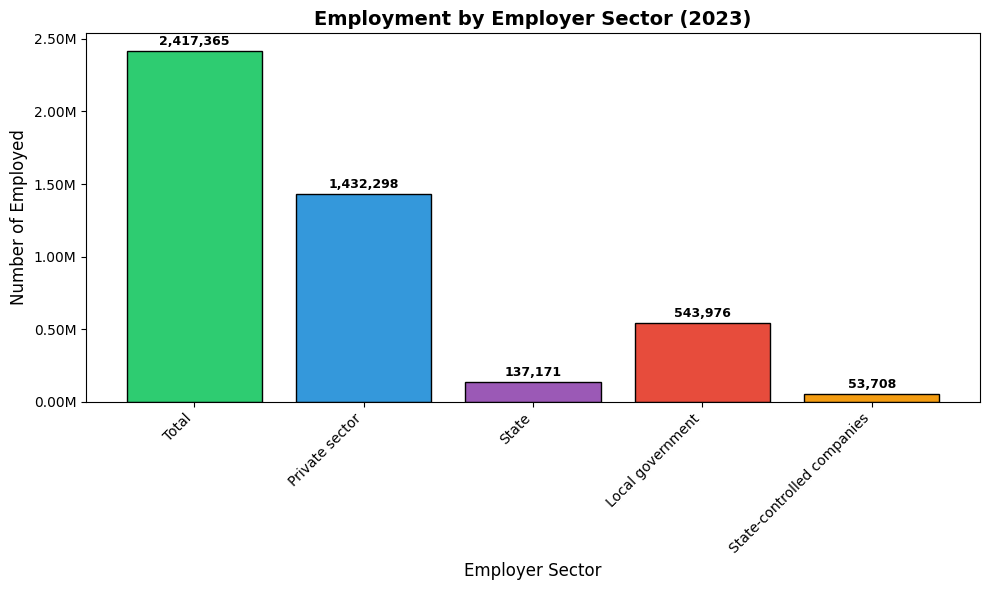

In [4]:
# Get ALL employer sectors by not filtering that dimension
# Only filter region, year, and gender
employer_year = "2023"
query = {
    "query": [
        {"code": "Työpaikan alue", "selection": {"filter": "item", "values": ["SSS"]}},
        {"code": "Vuosi", "selection": {"filter": "item", "values": [employer_year]}},
        {"code": "Sukupuoli", "selection": {"filter": "item", "values": ["SSS"]}},
        # Työnantajasektori - get all values
        {"code": "Työnantajasektori", "selection": {"filter": "item", "values": ["S", "1", "2", "3", "7"]}},
    ],
    "response": {"format": "json-stat2"}
}

response = requests.post(url, json=query)

if response.status_code == 200:
    data = response.json()
    
    # Get sector dimension
    sector_dim = data['dimension']['Työnantajasektori']
    sectors = list(sector_dim['category']['label'].values())
    values = data['value']
    
    employed_col = f"Employed_{employer_year}"
    employer_df = pd.DataFrame({'Sector': sectors, employed_col: values})
    display(employer_df)
    
    # Visualization: Employer Sector Bar Chart
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']
    bars = ax.bar(employer_df['Sector'], employer_df[employed_col], color=colors, edgecolor='black')
    ax.set_xlabel('Employer Sector', fontsize=12)
    ax.set_ylabel('Number of Employed', fontsize=12)
    ax.set_title(f'Employment by Employer Sector ({employer_year})', fontsize=14, fontweight='bold')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.2f}M'))
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 20000,
                f'{height:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"Error: {response.status_code}")
    print(response.text)

## Data Source 2: StatFin - Population by Age

**Goal:** Get population broken down by age groups (children 0-17, working age 18-64, pensioners 65+)

**Table:** `vaerak/statfin_vaerak_pxt_11re.px` - Population by age

In [5]:
# Explore population table
pop_url = f"{STATFIN_URL}/vaerak/statfin_vaerak_pxt_11re.px"
response = requests.get(pop_url)
pop_meta = response.json()

for var in pop_meta['variables']:
    print(f"\n📊 {var['code']}: {var['text']}")
    print(f"   Values: {len(var['values'])} options")
    for i, (code, text) in enumerate(zip(var['values'][:10], var['valueTexts'][:10])):
        print(f"   - {code}: {text}")
    if len(var['values']) > 10:
        print(f"   ... and {len(var['values']) - 10} more")


📊 Alue: Area
   Values: 309 options
   - SSS: WHOLE COUNTRY
   - KU020: Akaa
   - KU005: Alajärvi
   - KU009: Alavieska
   - KU010: Alavus
   - KU016: Asikkala
   - KU018: Askola
   - KU019: Aura
   - KU035: Brändö
   - KU043: Eckerö
   ... and 299 more

📊 Ikä: Age
   Values: 102 options
   - SSS: Total
   - 000: 0
   - 001: 1
   - 002: 2
   - 003: 3
   - 004: 4
   - 005: 5
   - 006: 6
   - 007: 7
   - 008: 8
   ... and 92 more

📊 Sukupuoli: Sex
   Values: 3 options
   - SSS: Total
   - 1: Males
   - 2: Females

📊 Vuosi: Year
   Values: 53 options
   - 1972: 1972
   - 1973: 1973
   - 1974: 1974
   - 1975: 1975
   - 1976: 1976
   - 1977: 1977
   - 1978: 1978
   - 1979: 1979
   - 1980: 1980
   - 1981: 1981
   ... and 43 more

📊 Tiedot: Information
   Values: 1 options
   - vaesto: Population 31 Dec


Population data for 2024:


,Age,Population
0,Total,5635971
1,0,43745
2,1,44025
3,2,46235
4,3,51428
5,4,48791
6,5,48232
7,6,50651
8,7,53711
9,8,56591


... 102 total age groups


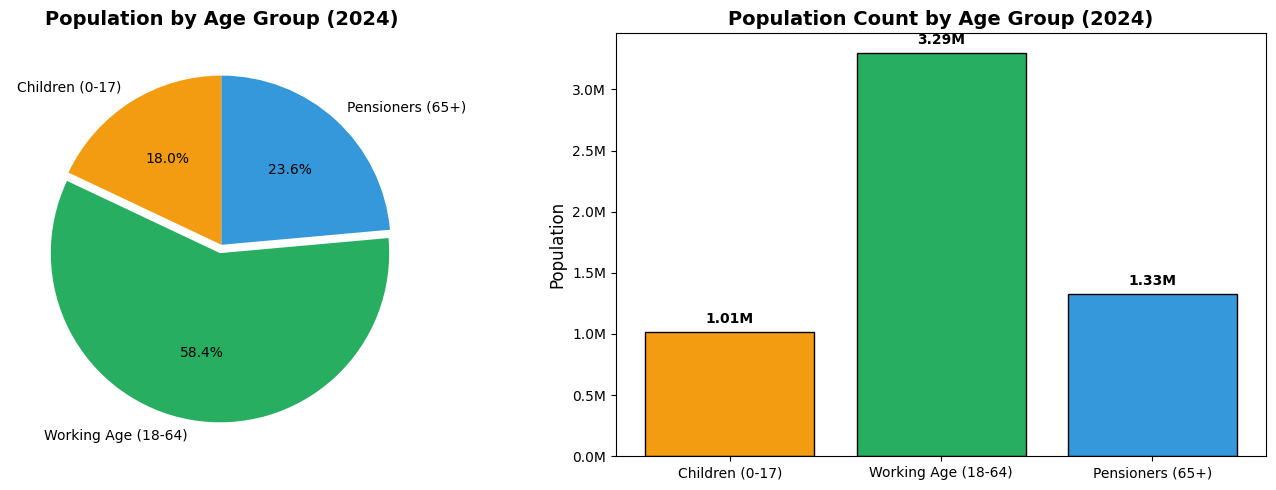

In [6]:
# Get population by age - whole country, all ages, latest year
# Get all age codes from metadata
age_codes = [v for v in pop_meta['variables'] if v['code'] == 'Ikä'][0]['values']
years = [v for v in pop_meta['variables'] if v['code'] == 'Vuosi'][0]['values']
pop_year = years[-1]

query = {
    "query": [
        {"code": "Alue", "selection": {"filter": "item", "values": ["SSS"]}},
        {"code": "Sukupuoli", "selection": {"filter": "item", "values": ["SSS"]}},
        {"code": "Vuosi", "selection": {"filter": "item", "values": [pop_year]}},
        {"code": "Ikä", "selection": {"filter": "item", "values": age_codes}},
    ],
    "response": {"format": "json-stat2"}
}

response = requests.post(pop_url, json=query)

if response.status_code == 200:
    pop_data = response.json()
    
    ages = list(pop_data['dimension']['Ikä']['category']['label'].values())
    values = pop_data['value']
    
    pop_df = pd.DataFrame({'Age': ages, 'Population': values})
    print(f"Population data for {pop_year}:")
    display(pop_df.head(20))
    print(f"... {len(pop_df)} total age groups")
    
    # Visualization: Population Age Groups Summary
    pop_numeric = pop_df[pop_df['Age'] != 'Total'].copy()
    pop_numeric['Age_num'] = pd.to_numeric(pop_numeric['Age'].str.replace(' -', '').str.replace('-', ''), errors='coerce')
    
    # Group into major categories
    children = pop_numeric[(pop_numeric['Age_num'] >= 0) & (pop_numeric['Age_num'] <= 17)]['Population'].sum()
    working_age = pop_numeric[(pop_numeric['Age_num'] >= 18) & (pop_numeric['Age_num'] <= 64)]['Population'].sum()
    pensioners = pop_numeric[pop_numeric['Age_num'] >= 65]['Population'].sum()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pie chart
    age_groups = ['Children (0-17)', 'Working Age (18-64)', 'Pensioners (65+)']
    age_values = [children, working_age, pensioners]
    colors = ['#f39c12', '#27ae60', '#3498db']
    ax1.pie(age_values, labels=age_groups, autopct='%1.1f%%', colors=colors, explode=(0, 0.05, 0), startangle=90)
    ax1.set_title(f'Population by Age Group ({pop_year})', fontsize=14, fontweight='bold')
    
    # Bar chart
    bars = ax2.bar(age_groups, age_values, color=colors, edgecolor='black')
    ax2.set_ylabel('Population', fontsize=12)
    ax2.set_title(f'Population Count by Age Group ({pop_year})', fontsize=14, fontweight='bold')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 50000,
                 f'{height/1e6:.2f}M', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Error: {response.status_code}")
    print(response.text)

## Data Source 3: StatFin - Employment Services (Hidden Unemployed)

**Goal:** Find people in employment measures who aren't counted as officially unemployed

**Table:** `tyonv/statfin_tyonv_pxt_12ti.px` - Jobseekers by activity

In [7]:
# Explore employment services table
es_url = f"{STATFIN_URL}/tyonv/statfin_tyonv_pxt_12ti.px"
response = requests.get(es_url)
es_meta = response.json()

for var in es_meta['variables']:
    print(f"\n📊 {var['code']}: {var['text']}")
    print(f"   Values: {len(var['values'])} options")
    for i, (code, text) in enumerate(zip(var['values'][:12], var['valueTexts'][:12])):
        print(f"   - {code}: {text}")
    if len(var['values']) > 12:
        print(f"   ... and {len(var['values']) - 12} more")


📊 Alue: Region
   Values: 421 options
   - SSS: WHOLE COUNTRY
   - KU020: Akaa
   - KU005: Alajärvi
   - KU009: Alavieska
   - KU010: Alavus
   - KU016: Asikkala
   - KU018: Askola
   - KU019: Aura
   - KU035: Brändö
   - KU043: Eckerö
   - KU046: Enonkoski
   - KU047: Enontekiö
   ... and 409 more

📊 Ammattiryhmä: Occupation
   Values: 434 options
   - SSS: SSS Total
   - 1111: 1111 Legislators
   - 1112: 1112 Senior central government officials
   - 1114: 1114 Senior officials of special-interest organiäations
   - 1120: 1120 Managing directors and chief executives
   - 1211: 1211 Finance managers
   - 1212: 1212 Human resource managers
   - 1213: 1213 Policy and planning managers
   - 1219: 1219 Business services and administration managers not elsewhere classified
   - 1221: 1221 Sales and marketing managers
   - 1222: 1222 Advertising and public relations managers
   - 1223: 1223 Research and development managers
   ... and 422 more

📊 Kuukausi: Month
   Values: 216 options
   - 

Latest month: 2025M12

Employment services data for 2025M12:


,Measure,Count
0,Unemployed jobseekers on calculation date (num...,351486
1,Vacancies on end-of-month calculation date (nu...,29320


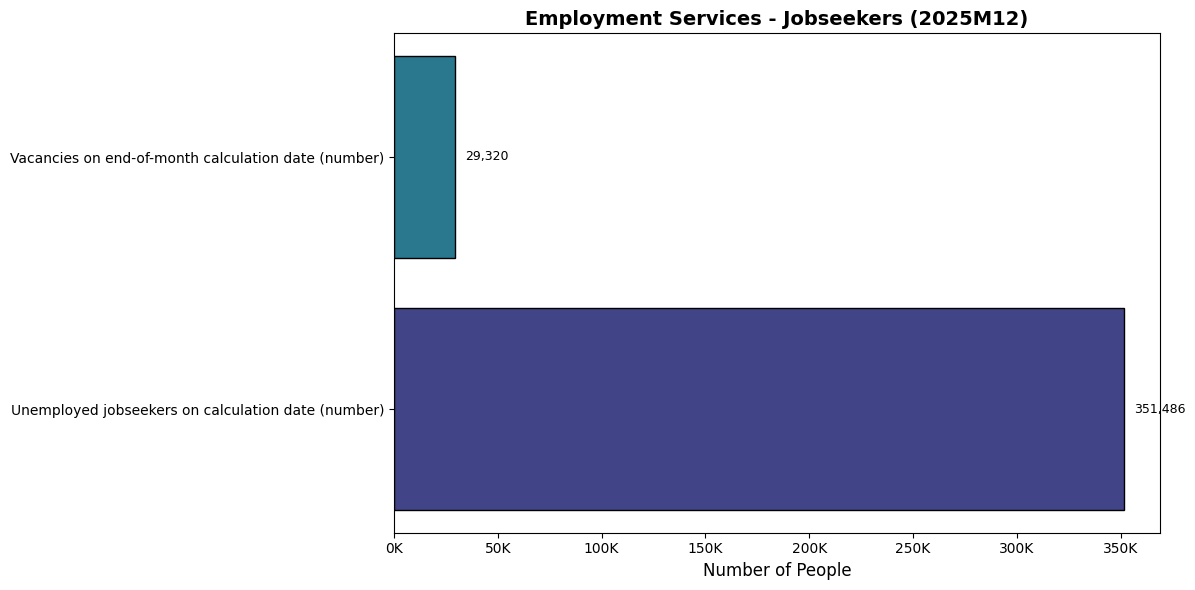

In [8]:
# Get unemployed jobseekers - total (all occupations)
months = [v for v in es_meta['variables'] if v['code'] == 'Kuukausi'][0]['values']
latest_month = months[-1]
print(f"Latest month: {latest_month}")

query = {
    "query": [
        {"code": "Alue", "selection": {"filter": "item", "values": ["SSS"]}},
        {"code": "Ammattiryhmä", "selection": {"filter": "item", "values": ["SSS"]}},  # Total
        {"code": "Kuukausi", "selection": {"filter": "item", "values": [latest_month]}},
    ],
    "response": {"format": "json-stat2"}
}

response = requests.post(es_url, json=query)

if response.status_code == 200:
    es_data = response.json()
    
    info_dim = es_data['dimension']['Tiedot']
    info_labels = list(info_dim['category']['label'].values())
    values = es_data['value']
    
    es_df = pd.DataFrame({'Measure': info_labels, 'Count': values})
    print(f"\nEmployment services data for {latest_month}:")
    display(es_df)
    
    # Visualization: Employment Services Bar Chart
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = plt.cm.viridis([0.2, 0.4, 0.6, 0.8, 0.9])[:len(es_df)]
    bars = ax.barh(es_df['Measure'], es_df['Count'], color=colors, edgecolor='black')
    ax.set_xlabel('Number of People', fontsize=12)
    ax.set_title(f'Employment Services - Jobseekers ({latest_month})', fontsize=14, fontweight='bold')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 5000, bar.get_y() + bar.get_height()/2,
                f'{width:,.0f}', va='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print(f"Error: {response.status_code}")
    print(response.text)

## Data Source 4: Kela Open Data

**Goal:** Find working poor indicators - people receiving income supplements

**Source:** avoindata.suomi.fi - Kela datasets

Let's see what Kela open data is available:

In [9]:
# Search Kela datasets on avoindata.suomi.fi
kela_api = "https://www.avoindata.fi/data/api/3/action/package_search"
response = requests.get(kela_api, params={"q": "kela", "rows": 30})
kela_search = response.json()

if kela_search['success']:
    print(f"Found {kela_search['result']['count']} Kela-related datasets:\n")
    for ds in kela_search['result']['results'][:15]:
        print(f"📦 {ds['title']}")
        print(f"   ID: {ds['name']}")
        # Show formats
        formats = [r['format'] for r in ds.get('resources', [])]
        print(f"   Formats: {', '.join(set(formats))}")
        print()

Found 37 Kela-related datasets:

📦 Kelan maksamat eläke-etuudet
   ID: kelan-maksamat-elake-etuudet
   Formats: CSV, JSON

📦 Kelan työttömyysetuudet korvausperusteen mukaan
   ID: kelan-tyottomyysetuudet-korvausperusteen-mukaan
   Formats: CSV, JSON

📦 Kelan maksaman perustoimeentulotuen menot ja palautukset
   ID: kelan-maksaman-perustoimeentulotuen-menot-ja-palautukset
   Formats: CSV, JSON

📦 Kelan työttömyysetuuksien saajat kuukauden lopussa
   ID: kelan-tyottomyysetuuksien-saajat-kuukauden-lopussa
   Formats: CSV, JSON

📦 Kelan etuuksien saajat ja maksetut etuudet
   ID: kelan-etuuksien-saajat-ja-maksetut-etuudet
   Formats: CSV, JSON

📦 Kelan sairaanhoitovakuutuksen suorakorvaukset 2011-2014
   ID: kelan-sairaanhoitovakuutuksen-suorakorvaukset-2011-2014
   Formats: XLSX, CSV

📦 Kelan eläke-etuuden saajat ja keskimääräiset etuudet
   ID: kelan-elake-etuuden-saajat-ja-keskimaaraiset-etuudet
   Formats: CSV, JSON

📦 Perustoimeentulotuen saajat
   ID: perustoimeentulotuen-saajat
   F

Dataset: Kelan työttömyysetuuksien saajat kuukauden lopussa

Fetching CSV...
Shape: (779362, 12)
Columns: ['aikatyyppi', 'kuukausi_nro', 'vuosikuukausi', 'vuosi', 'kunta_nro', 'kunta_nimi', 'ikaryhma', 'sukupuoli', 'etuus', 'korvausperuste', 'korvauslaji', 'saaja_lkm']

Unique 'etuus' values:
<StringArray>
[ 'PeruspÃ¤ivÃ¤raha',  'TyÃ¶markkinatuki',         'YhteensÃ¤',
   'Muutosturvaraha', 'Liikkuvuusavustus']
Length: 5, dtype: str


,aikatyyppi,kuukausi_nro,vuosikuukausi,vuosi,kunta_nro,kunta_nimi,ikaryhma,sukupuoli,etuus,korvausperuste,korvauslaji,saaja_lkm
0,Kuukausi,5,202505,2025,92,Vantaa,Tieto puuttuu,Tuntematon,PeruspÃ¤ivÃ¤raha,-Kuntouttava tyÃ¶toiminta,-Muu sosiaalietuus vÃ¤hentÃ¤nyt,1
1,Kuukausi,5,202505,2025,859,TyrnÃ¤vÃ¤,Tieto puuttuu,Tuntematon,PeruspÃ¤ivÃ¤raha,-Kuntouttava tyÃ¶toiminta,-Soviteltu tuki,1
2,Kuukausi,5,202505,2025,837,Tampere,Tieto puuttuu,Tuntematon,PeruspÃ¤ivÃ¤raha,-Kuntouttava tyÃ¶toiminta,-Soviteltu tuki,1
3,Kuukausi,5,202505,2025,697,RistijÃ¤rvi,Tieto puuttuu,Tuntematon,PeruspÃ¤ivÃ¤raha,-Kuntouttava tyÃ¶toiminta,-Soviteltu tuki,1
4,Kuukausi,5,202505,2025,562,Orivesi,Tieto puuttuu,Tuntematon,PeruspÃ¤ivÃ¤raha,-Kuntouttava tyÃ¶toiminta,-Soviteltu tuki,1
5,Kuukausi,5,202505,2025,494,Muhos,Tieto puuttuu,Tuntematon,PeruspÃ¤ivÃ¤raha,-Kuntouttava tyÃ¶toiminta,-Soviteltu tuki,1
6,Kuukausi,5,202505,2025,288,Kruunupyy,Tieto puuttuu,Tuntematon,PeruspÃ¤ivÃ¤raha,-Kuntouttava tyÃ¶toiminta,-Soviteltu tuki,1
7,Kuukausi,5,202505,2025,286,Kouvola,Tieto puuttuu,Tuntematon,PeruspÃ¤ivÃ¤raha,-Kuntouttava tyÃ¶toiminta,-Soviteltu tuki,2
8,Kuukausi,5,202505,2025,257,Kirkkonummi,Tieto puuttuu,Tuntematon,PeruspÃ¤ivÃ¤raha,-Kuntouttava tyÃ¶toiminta,-Soviteltu tuki,1
9,Kuukausi,5,202505,2025,213,Kangasniemi,Tieto puuttuu,Tuntematon,PeruspÃ¤ivÃ¤raha,-Kuntouttava tyÃ¶toiminta,-Soviteltu tuki,1


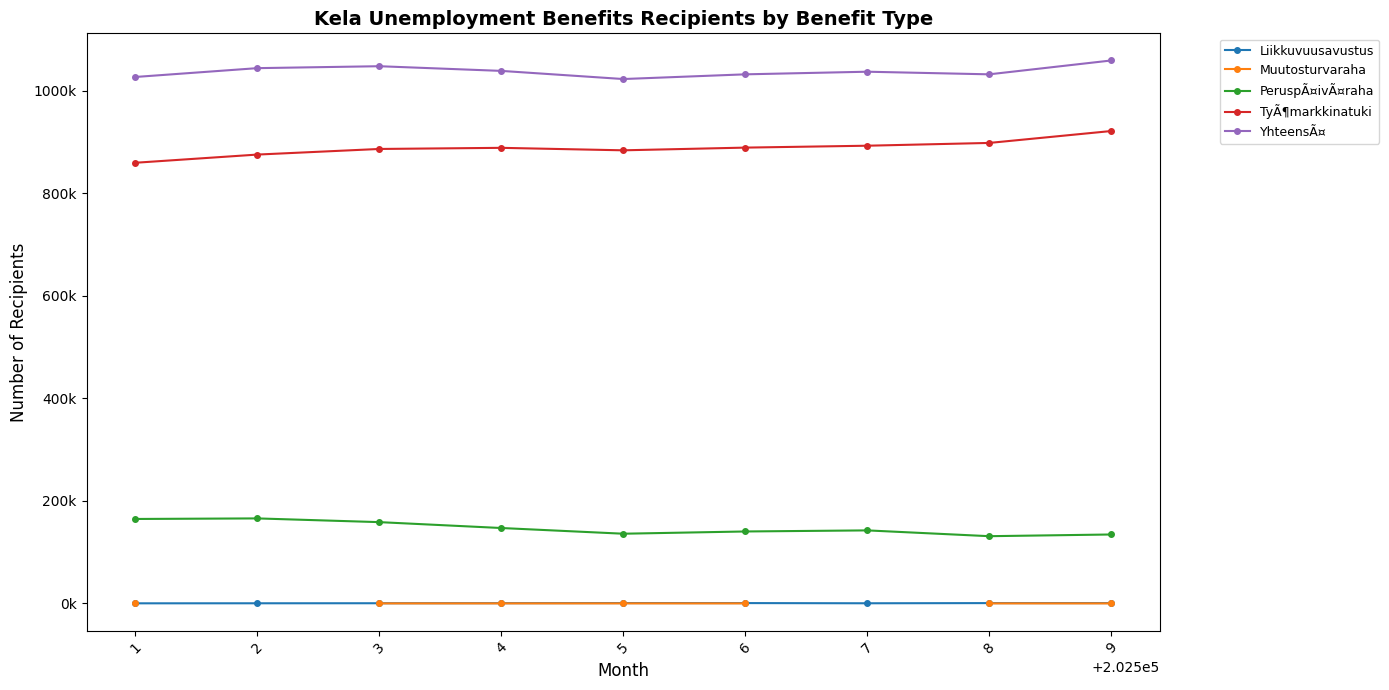


📊 Latest month breakdown by benefit type:
  YhteensÃ¤: 1,058,768 recipients
  TyÃ¶markkinatuki: 921,186 recipients
  PeruspÃ¤ivÃ¤raha: 134,394 recipients
  Liikkuvuusavustus: 600 recipients
  Muutosturvaraha: 8 recipients


In [10]:
# Fetch Kela unemployment benefits data
ds_url = "https://www.avoindata.fi/data/api/3/action/package_show"
response = requests.get(ds_url, params={"id": "kelan-tyottomyysetuuksien-saajat-kuukauden-lopussa"})

if response.status_code == 200 and response.json()['success']:
    ds = response.json()['result']
    print(f"Dataset: {ds['title']}\n")
    
    # Find CSV resource
    for r in ds['resources']:
        if r['format'] == 'CSV':
            print(f"Fetching CSV...")
            csv_response = requests.get(r['url'])
            if csv_response.status_code == 200:
                from io import StringIO
                # Try comma separator
                kela_unemp_df = pd.read_csv(StringIO(csv_response.text), sep=',', encoding='utf-8')
                print(f"Shape: {kela_unemp_df.shape}")
                print(f"Columns: {list(kela_unemp_df.columns)}")
                print(f"\nUnique 'etuus' values:")
                print(kela_unemp_df['etuus'].unique())
                display(kela_unemp_df.head(10))
            break

    # Group by both month AND benefit type (etuus)
    monthly_by_etuus = kela_unemp_df.groupby(['vuosikuukausi', 'etuus'])['saaja_lkm'].sum().reset_index()
    monthly_by_etuus = monthly_by_etuus.sort_values('vuosikuukausi')
    
    # Get last 24 months
    last_months = monthly_by_etuus['vuosikuukausi'].unique()[-24:]
    monthly_by_etuus = monthly_by_etuus[monthly_by_etuus['vuosikuukausi'].isin(last_months)]
    
    # Pivot for plotting - each etuus as a separate line
    pivot_df = monthly_by_etuus.pivot(index='vuosikuukausi', columns='etuus', values='saaja_lkm')
    
    # matplotlib visualization with multiple lines
    fig, ax = plt.subplots(figsize=(14, 7))
    
    for col in pivot_df.columns:
        ax.plot(pivot_df.index, pivot_df[col], marker='o', linestyle='-', label=col, markersize=4)
    
    ax.set_title('Kela Unemployment Benefits Recipients by Benefit Type', fontsize=14, fontweight='bold')
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Number of Recipients', fontsize=12)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}k'))
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n📊 Latest month breakdown by benefit type:")
    latest_month = monthly_by_etuus['vuosikuukausi'].max()
    latest_data = monthly_by_etuus[monthly_by_etuus['vuosikuukausi'] == latest_month]
    for _, row in latest_data.sort_values('saaja_lkm', ascending=False).iterrows():
        print(f"  {row['etuus']}: {row['saaja_lkm']:,.0f} recipients")

In [11]:
# Aggregate Kela unemployment data by month - get total recipients per month
# Filter to "Yhteensä" (Total) to avoid double counting benefit types

# ⚠️ VERIFY: Check what dimensions exist - are there multiple "Yhteensä" rows?
print("📊 DIMENSION CHECK for Kela Unemployment Data:")
print(f"Columns: {list(kela_unemp_df.columns)}")

# Check how many rows match "Yhteensä" per month
yhteensa_rows = kela_unemp_df[kela_unemp_df['etuus'].str.contains('Yhteens', na=False)]
print(f"\nRows with 'Yhteensä' in etuus: {len(yhteensa_rows)}")
print(f"Rows per month: {yhteensa_rows.groupby('vuosikuukausi').size().unique()}")

# If there are other dimensions (kunta, ikaryhma, etc.), we need to filter more carefully
if 'kunta_nimi' in kela_unemp_df.columns:
    print(f"\nHas municipality column - need to filter to 'Koko maa'")
    if 'Koko maa' in kela_unemp_df['kunta_nimi'].values:
        yhteensa_rows = yhteensa_rows[yhteensa_rows['kunta_nimi'] == 'Koko maa']
        print(f"✅ Filtered to national total - {len(yhteensa_rows)} rows")

if 'ikaryhma' in kela_unemp_df.columns:
    print(f"Has age group column - checking for total...")
    if yhteensa_rows['ikaryhma'].str.contains('Yhteens|Kaikki', na=False).any():
        yhteensa_rows = yhteensa_rows[yhteensa_rows['ikaryhma'].str.contains('Yhteens|Kaikki', na=False)]
        print(f"✅ Filtered to total age group - {len(yhteensa_rows)} rows")

total_by_month = yhteensa_rows.groupby('vuosikuukausi')['saaja_lkm'].sum()

# Convert to DataFrame and sort
kela_monthly = total_by_month.reset_index()
kela_monthly.columns = ['Month', 'Recipients']
kela_monthly = kela_monthly.sort_values('Month')

print("\nKELA UNEMPLOYMENT BENEFITS - Monthly totals (verified)")
print("=" * 50)
print(f"Data range: {kela_monthly['Month'].min()} to {kela_monthly['Month'].max()}")
print(f"\nRecent months:")
display(kela_monthly.tail(12))

📊 DIMENSION CHECK for Kela Unemployment Data:
Columns: ['aikatyyppi', 'kuukausi_nro', 'vuosikuukausi', 'vuosi', 'kunta_nro', 'kunta_nimi', 'ikaryhma', 'sukupuoli', 'etuus', 'korvausperuste', 'korvauslaji', 'saaja_lkm']

Rows with 'Yhteensä' in etuus: 348790
Rows per month: [39269 39645 39861 39558 38716 37702 36856 37994 39189]

Has municipality column - need to filter to 'Koko maa'
Has age group column - checking for total...

KELA UNEMPLOYMENT BENEFITS - Monthly totals (verified)
Data range: 202501 to 202509

Recent months:


,Month,Recipients
0,202501,1026599
1,202502,1043815
2,202503,1047581
3,202504,1038463
4,202505,1022585
5,202506,1031746
6,202507,1036859
7,202508,1031762
8,202509,1058768


## Data Source 5: Kela Housing Allowance (Asumistuki)

In [12]:
# Fetch housing allowance data
response = requests.get(ds_url, params={"id": "maksetut-yleiset-asumistuet1"})

if response.status_code == 200 and response.json()['success']:
    ds = response.json()['result']
    print(f"Dataset: {ds['title']}\n")
    
    for r in ds['resources']:
        if r['format'] == 'CSV':
            print(f"Fetching CSV...")
            csv_response = requests.get(r['url'])
            if csv_response.status_code == 200:
                from io import StringIO
                kela_housing_df = pd.read_csv(StringIO(csv_response.text), sep=',', encoding='utf-8')
                print(f"Shape: {kela_housing_df.shape}")
                print(f"Columns: {list(kela_housing_df.columns)}")
                display(kela_housing_df.head(5))
            break

Dataset: Maksetut yleiset asumistuet

Fetching CSV...
Shape: (2017884, 11)
Columns: ['aikatyyppi', 'kuukausi_nro', 'vuosikuukausi', 'vuosi', 'kunta_nro', 'kunta_nimi', 'ikaryhma', 'ruokakuntatyyppi', 'hallintamuoto', 'elamantilanne', 'maksettu_eur']


,aikatyyppi,kuukausi_nro,vuosikuukausi,vuosi,kunta_nro,kunta_nimi,ikaryhma,ruokakuntatyyppi,hallintamuoto,elamantilanne,maksettu_eur
0,NeljÃ¤nnesvuosi,6,202506,2025,410,Laukaa,25-29,Yksin asuvat,-Tavanomainen vuokra-asunto,Muut ruokakunnat,4714.15
1,NeljÃ¤nnesvuosi,6,202506,2025,408,Lapua,25-29,Yksin asuvat,-Tavanomainen vuokra-asunto,Muut ruokakunnat,1996.40
2,NeljÃ¤nnesvuosi,6,202506,2025,407,LapinjÃ¤rvi,25-29,Yksin asuvat,-Tavanomainen vuokra-asunto,Muut ruokakunnat,262.15
3,NeljÃ¤nnesvuosi,6,202506,2025,405,Lappeenranta,25-29,Yksin asuvat,-Tavanomainen vuokra-asunto,Muut ruokakunnat,66030.74
4,NeljÃ¤nnesvuosi,6,202506,2025,402,Lapinlahti,25-29,Yksin asuvat,-Tavanomainen vuokra-asunto,Muut ruokakunnat,4028.66


📊 AVAILABLE DIMENSIONS IN HOUSING ALLOWANCE DATA:
Columns: ['aikatyyppi', 'kuukausi_nro', 'vuosikuukausi', 'vuosi', 'kunta_nro', 'kunta_nimi', 'ikaryhma', 'ruokakuntatyyppi', 'hallintamuoto', 'elamantilanne', 'maksettu_eur']

Unique 'elamantilanne' (life situation) values:
<StringArray>
[           'Muut ruokakunnat', 'TyÃ¶ssÃ¤ olevat ruokakunnat',
   'ElÃ¤kkeensaajaruokakunnat',       'Opiskelijaruokakunnat',
    'TyÃ¶ttÃ¶mÃ¤t ruokakunnat']
Length: 5, dtype: str

KELA HOUSING ALLOWANCE - Payments by Life Situation
Data range: 202501 to 202512

📊 Latest month breakdown (202512):
  TyÃ¶ttÃ¶mÃ¤t ruokakunnat: €5,657,772,510
  Opiskelijaruokakunnat: €2,010,298,685
  TyÃ¶ssÃ¤ olevat ruokakunnat: €1,664,215,559
  Muut ruokakunnat: €1,468,557,124
  ElÃ¤kkeensaajaruokakunnat: €269,490,701


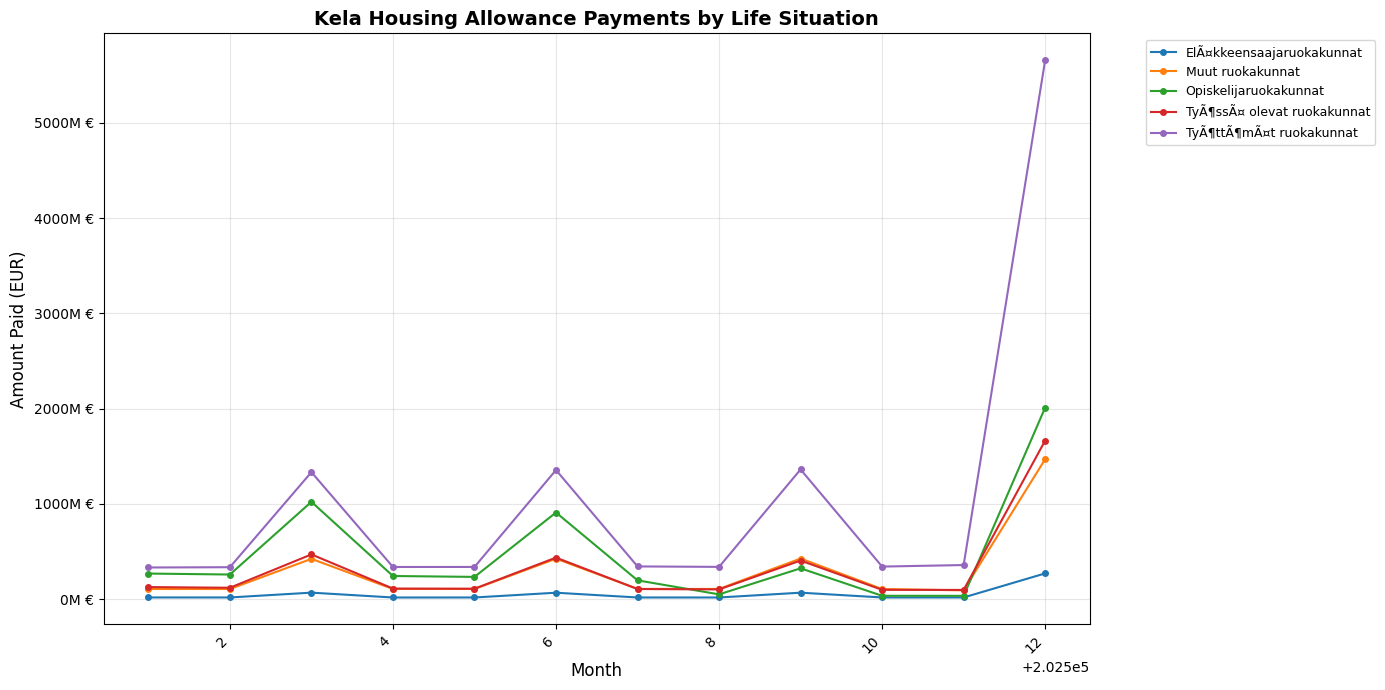

In [13]:
# Housing Allowance Analysis - by life situation (elamantilanne)
# Show unique dimensions first
print("📊 AVAILABLE DIMENSIONS IN HOUSING ALLOWANCE DATA:")
print(f"Columns: {list(kela_housing_df.columns)}")
print(f"\nUnique 'elamantilanne' (life situation) values:")
print(kela_housing_df['elamantilanne'].unique())

# Group by BOTH month AND life situation to avoid summing different categories
housing_by_situation = kela_housing_df.groupby(['vuosikuukausi', 'elamantilanne'])['maksettu_eur'].sum().reset_index()
housing_by_situation = housing_by_situation.sort_values('vuosikuukausi')

# Get last 24 months
last_months = housing_by_situation['vuosikuukausi'].unique()[-24:]
housing_by_situation = housing_by_situation[housing_by_situation['vuosikuukausi'].isin(last_months)]

# Pivot for visualization
pivot_housing = housing_by_situation.pivot(index='vuosikuukausi', columns='elamantilanne', values='maksettu_eur')

print("\nKELA HOUSING ALLOWANCE - Payments by Life Situation")
print("=" * 60)
print(f"Data range: {housing_by_situation['vuosikuukausi'].min()} to {housing_by_situation['vuosikuukausi'].max()}")

# Summary for latest month
latest_month = housing_by_situation['vuosikuukausi'].max()
latest_data = housing_by_situation[housing_by_situation['vuosikuukausi'] == latest_month]
print(f"\n📊 Latest month breakdown ({latest_month}):")
for _, row in latest_data.sort_values('maksettu_eur', ascending=False).iterrows():
    print(f"  {row['elamantilanne']}: €{row['maksettu_eur']:,.0f}")

# Visualization: Housing Allowance by Life Situation
fig, ax = plt.subplots(figsize=(14, 7))

for col in pivot_housing.columns:
    ax.plot(pivot_housing.index, pivot_housing[col], marker='o', linestyle='-', label=col, markersize=4)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Amount Paid (EUR)', fontsize=12)
ax.set_title('Kela Housing Allowance Payments by Life Situation', fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M €'))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Data Source 6: Kela Basic Income Support (Perustoimeentulotuki)

Dataset: Perustoimeentulotuen saajat

Fetching CSV...
Shape: (241060, 8)
Columns: ['aikatyyppi', 'kuukausi_nro', 'vuosikuukausi', 'vuosi', 'kunta_nro', 'kunta_nimi', 'ikaryhma', 'saaja_lkm']

📊 DIMENSION CHECK:
Unique municipalities: 299
Sample municipalities: ['Koko maa', 'Ã\x84Ã¤nekoski', 'Ã\x84htÃ¤ri', 'YpÃ¤jÃ¤', 'YlÃ¶jÃ¤rvi']
✅ Found national total with keyword: 'Koko maa' (456 rows)

Time types (aikatyyppi): ['VuosikertymÃ¤', 'Kuukausi']
✅ Found monthly data with keyword: 'Kuukausi' (116964 rows)

📊 Filtered records: 0

⚠️ Filters too strict - using broader approach
Using 116964 records

📊 Basic Income Support by Age Group (202512):
  25-64: 130,633 recipients
  0-17: 58,244 recipients
  18-24: 30,699 recipients
  65-: 5,291 recipients
  Tieto puuttuu: 305 recipients

📊 Monthly total: 225,172

Monthly data points: 108


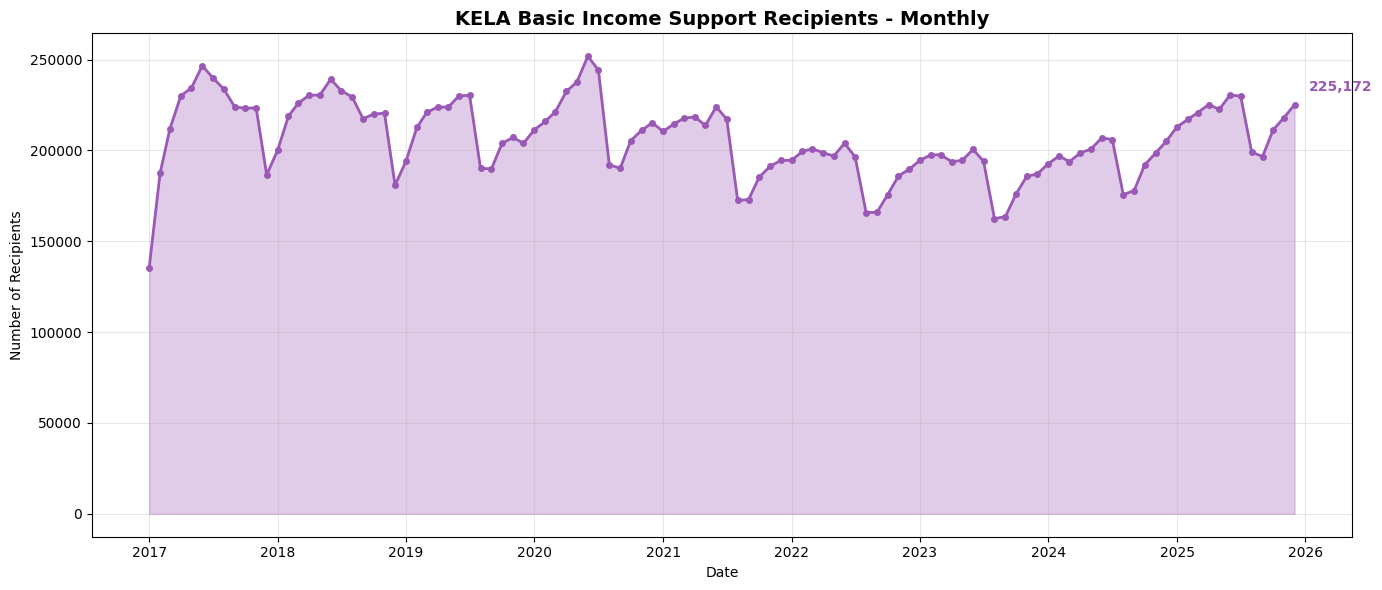


Data range: 2017-01 to 2025-12
Latest month (2025-12): 225,172 recipients


In [45]:
# Fetch basic income support recipients
response = requests.get(ds_url, params={"id": "perustoimeentulotuen-saajat"})

if response.status_code == 200 and response.json()['success']:
    ds = response.json()['result']
    print(f"Dataset: {ds['title']}\n")
    
    for r in ds['resources']:
        if r['format'] == 'CSV':
            print(f"Fetching CSV...")
            csv_response = requests.get(r['url'])
            if csv_response.status_code == 200:
                from io import StringIO
                kela_income_df = pd.read_csv(StringIO(csv_response.text), sep=',', encoding='utf-8')
                print(f"Shape: {kela_income_df.shape}")
                print(f"Columns: {list(kela_income_df.columns)}")
            break

    # ⚠️ CHECK DIMENSIONS TO AVOID OVER-COUNTING
    print("\n📊 DIMENSION CHECK:")
    print(f"Unique municipalities: {kela_income_df['kunta_nimi'].nunique()}")
    print(f"Sample municipalities: {list(kela_income_df['kunta_nimi'].unique()[:5])}")
    
    # Check for national total with various possible names
    national_keywords = ['Koko maa', 'Yhteens', 'KOKO MAA', 'Manner-Suomi']
    national_found = None
    for kw in national_keywords:
        matches = kela_income_df[kela_income_df['kunta_nimi'].str.contains(kw, na=False, case=False)]
        if len(matches) > 0:
            national_found = kw
            print(f"✅ Found national total with keyword: '{kw}' ({len(matches)} rows)")
            break
    
    if 'aikatyyppi' in kela_income_df.columns:
        print(f"\nTime types (aikatyyppi): {list(kela_income_df['aikatyyppi'].unique())}")
        # Check actual values for monthly filter
        monthly_keywords = ['Kuukausi', 'kuukausi', 'Monthly']
        for kw in monthly_keywords:
            matches = kela_income_df[kela_income_df['aikatyyppi'].str.contains(kw, na=False, case=False)]
            if len(matches) > 0:
                print(f"✅ Found monthly data with keyword: '{kw}' ({len(matches)} rows)")
                monthly_filter = kela_income_df['aikatyyppi'].str.contains(kw, na=False, case=False)
                break
        else:
            # No monthly filter found - use all data
            print("⚠️ No monthly filter found - using all data")
            monthly_filter = pd.Series([True] * len(kela_income_df))
    else:
        monthly_filter = pd.Series([True] * len(kela_income_df))

    # Apply national filter if found
    if national_found:
        national_filter = kela_income_df['kunta_nimi'].str.contains(national_found, na=False, case=False)
        kela_income_national = kela_income_df[monthly_filter & national_filter].copy()
    else:
        # No national total - aggregate all municipalities
        print("⚠️ No national total row - will aggregate municipalities")
        kela_income_national = kela_income_df[monthly_filter].copy()
    
    print(f"\n📊 Filtered records: {len(kela_income_national)}")
    
    if len(kela_income_national) == 0:
        # Fallback: just aggregate all monthly data by month and age group
        print("\n⚠️ Filters too strict - using broader approach")
        # Use all data but aggregate properly by month
        if 'aikatyyppi' in kela_income_df.columns:
            # Try to get monthly data with partial matching
            kela_income_national = kela_income_df[kela_income_df['aikatyyppi'].str.lower().str.contains('kuu', na=False)].copy()
            if len(kela_income_national) == 0:
                kela_income_national = kela_income_df.copy()
        else:
            kela_income_national = kela_income_df.copy()
        print(f"Using {len(kela_income_national)} records")
    
    # Group by month AND age group for breakdown (sum across municipalities if needed)
    if 'ikaryhma' in kela_income_national.columns:
        income_by_age = kela_income_national.groupby(['vuosikuukausi', 'ikaryhma'])['saaja_lkm'].sum().reset_index()
        
        # Get latest month breakdown
        latest_month = income_by_age['vuosikuukausi'].max()
        latest_data = income_by_age[income_by_age['vuosikuukausi'] == latest_month]
        
        print(f"\n📊 Basic Income Support by Age Group ({latest_month}):")
        for _, row in latest_data.sort_values('saaja_lkm', ascending=False).iterrows():
            print(f"  {row['ikaryhma']}: {row['saaja_lkm']:,} recipients")
        
        # Sum age groups for total
        national_total = latest_data['saaja_lkm'].sum()
        print(f"\n📊 Monthly total: {national_total:,}")
    
    # For time series - sum by month (across all age groups)
    income_monthly = kela_income_national.groupby('vuosikuukausi')['saaja_lkm'].sum().reset_index()
    income_monthly.columns = ['Month', 'Recipients']
    income_monthly['Date'] = pd.to_datetime(income_monthly['Month'].astype(str), format='%Y%m')
    income_monthly = income_monthly.sort_values('Date')
    income_monthly['Label'] = income_monthly['Date'].dt.strftime('%Y-%m')
    
    print(f"\nMonthly data points: {len(income_monthly)}")

    # Chart
    if len(income_monthly) > 0:
        plt.figure(figsize=(14, 6))
        plt.fill_between(income_monthly['Date'], income_monthly['Recipients'], alpha=0.3, color='#9b59b6')
        plt.plot(income_monthly['Date'], income_monthly['Recipients'], color='#9b59b6', linewidth=2, marker='o', markersize=4)
        plt.title('KELA Basic Income Support Recipients - Monthly', fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Number of Recipients')
        plt.grid(True, alpha=0.3)
        
        plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
        
        latest_row = income_monthly.iloc[-1]
        plt.annotate(f'{latest_row["Recipients"]:,.0f}', 
                     xy=(latest_row['Date'], latest_row['Recipients']),
                     xytext=(10, 10), textcoords='offset points',
                     fontsize=10, fontweight='bold', color='#9b59b6')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nData range: {income_monthly['Label'].min()} to {income_monthly['Label'].max()}")
        print(f"Latest month ({latest_row['Label']}): {latest_row['Recipients']:,} recipients")
    else:
        print("No data found!")

In [15]:
# Aggregate basic income support by month - whole country only
kela_income_national = kela_income_df[kela_income_df['kunta_nimi'] == 'Koko maa']

# Group by month and sum recipients
income_monthly = kela_income_national.groupby('vuosikuukausi')['saaja_lkm'].sum().reset_index()
income_monthly.columns = ['Month', 'Recipients']
income_monthly = income_monthly.sort_values('Month')

print("KELA BASIC INCOME SUPPORT (Perustoimeentulotuki) - Monthly totals")
print("=" * 60)
print(f"Data range: {income_monthly['Month'].min()} to {income_monthly['Month'].max()}")
print(f"\nRecent months:")
display(income_monthly.tail(12))

# Also show by age group for latest month
latest = income_monthly['Month'].max()
by_age = kela_income_national[kela_income_national['vuosikuukausi'] == latest][['ikaryhma', 'saaja_lkm']]
print(f"\nBy age group ({latest}):")
display(by_age)

KELA BASIC INCOME SUPPORT (Perustoimeentulotuki) - Monthly totals
Data range: 201701 to 202512

Recent months:


,Month,Recipients
96,202501,212985
97,202502,240800
98,202503,260490
99,202504,276877
100,202505,289049
101,202506,308492
102,202507,321324
103,202508,330044
104,202509,338112
105,202510,347379



By age group (202512):


,ikaryhma,saaja_lkm
2351,Tieto puuttuu,0
2352,65-,14509
2353,25-64,205553
2354,18-24,59355
2355,0-17,85612


## Data Source 7: Eurostat - EU Unemployment Comparison

In [16]:
# Fetch Eurostat unemployment rates for EU countries
# Using the SDMX REST API
eurostat_url = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/une_rt_m"

# Get monthly unemployment rate, seasonally adjusted, total, for Nordic + EU
params = {
    "format": "JSON",
    "geo": "FI,SE,DK,NO,DE,EU27_2020",  # Finland, Sweden, Denmark, Norway, Germany, EU27
    "s_adj": "SA",  # Seasonally adjusted
    "age": "TOTAL",
    "sex": "T",  # Total
    "unit": "PC_ACT",  # Percentage of active population
}

response = requests.get(eurostat_url, params=params)
print(f"Status: {response.status_code}")

if response.status_code == 200:
    eurostat_data = response.json()
    print(f"Dataset: {eurostat_data.get('label', 'Unemployment rate')}")
    print(f"Keys: {list(eurostat_data.keys())}")
else:
    print(f"Error: {response.text[:500]}")

Status: 200
Dataset: Unemployment by sex and age - monthly data
Keys: ['version', 'class', 'label', 'source', 'updated', 'value', 'status', 'id', 'size', 'dimension', 'extension']


EUROSTAT - Latest unemployment rates (%):


,Country,Time,Unemployment_rate
24,Malta,2025-12,1.9
20,Japan,2025-12,2.9
18,Ireland,2025-12,3.6
32,Slovenia,2025-12,3.7
16,Hungary,2025-12,3.9
30,Romania,2025-12,4.6
17,Iceland,2025-11,5.0
29,Portugal,2025-12,5.1
11,European Union - 27 countries (from 2020),2025-12,5.2
7,Denmark,2025-12,5.3


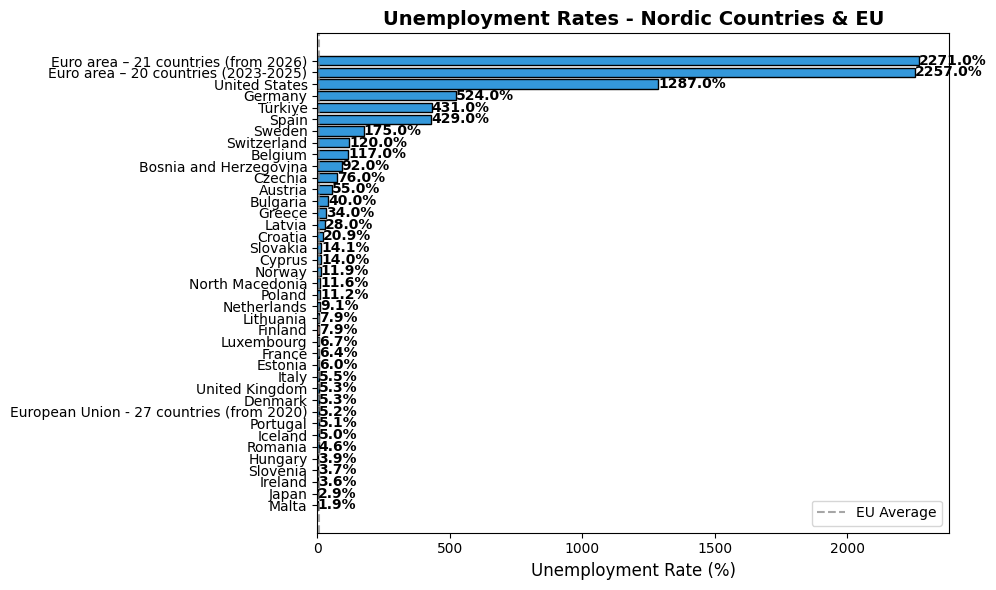

In [17]:
# Parse Eurostat JSON-stat format
# The structure has multiple dimensions, need to calculate properly

dims = eurostat_data['dimension']
sizes = eurostat_data['size']
dim_ids = eurostat_data['id']

# Get dimension info
geo_labels = dims['geo']['category']['label']
time_labels = dims['time']['category']['label']

# Values is a sparse dict with flat index
values = eurostat_data['value']

# Build reverse index mapping
def get_position_labels(dim_id, flat_idx, sizes, dim_ids):
    """Convert flat index to position in each dimension"""
    positions = []
    for i, (d_id, size) in enumerate(zip(dim_ids, sizes)):
        # Calculate position in this dimension
        divisor = 1
        for j in range(i + 1, len(sizes)):
            divisor *= sizes[j]
        pos = (flat_idx // divisor) % size
        positions.append(pos)
    return positions

# Get all geo and time codes in order
geo_codes = list(dims['geo']['category']['index'].keys())
geo_order = [dims['geo']['category']['index'][c] for c in geo_codes]
geo_sorted = [c for _, c in sorted(zip(geo_order, geo_codes))]

time_codes = list(dims['time']['category']['index'].keys())
time_order = [dims['time']['category']['index'][c] for c in time_codes]
time_sorted = [c for _, c in sorted(zip(time_order, time_codes))]

# Build records
records = []
for idx_str, val in values.items():
    flat_idx = int(idx_str)
    positions = get_position_labels(None, flat_idx, sizes, dim_ids)
    
    # Find geo and time positions (they are at specific indices in dim_ids)
    geo_dim_idx = dim_ids.index('geo')
    time_dim_idx = dim_ids.index('time')
    
    geo_code = geo_sorted[positions[geo_dim_idx]]
    time_code = time_sorted[positions[time_dim_idx]]
    
    records.append({
        'Country': geo_labels[geo_code],
        'Country_code': geo_code,
        'Time': time_code,
        'Unemployment_rate': val
    })

eurostat_df = pd.DataFrame(records)

# Get latest time for each country
latest_data = eurostat_df.sort_values('Time').groupby('Country').last().reset_index()
print("EUROSTAT - Latest unemployment rates (%):")
display(latest_data[['Country', 'Time', 'Unemployment_rate']].sort_values('Unemployment_rate'))

# Visualization: EU Unemployment Comparison
fig, ax = plt.subplots(figsize=(10, 6))
latest_sorted = latest_data.sort_values('Unemployment_rate')
colors = ['#e74c3c' if c == 'Finland' else '#3498db' for c in latest_sorted['Country']]
bars = ax.barh(latest_sorted['Country'], latest_sorted['Unemployment_rate'], color=colors, edgecolor='black')
ax.set_xlabel('Unemployment Rate (%)', fontsize=12)
ax.set_title('Unemployment Rates - Nordic Countries & EU', fontsize=14, fontweight='bold')
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height()/2,
            f'{width:.1f}%', va='center', fontsize=10, fontweight='bold')

# EU average reference line if present
eu_name = 'European Union - 27 countries (from 2020)'
if eu_name in latest_sorted['Country'].values:
    eu_avg = latest_sorted.loc[latest_sorted['Country'] == eu_name, 'Unemployment_rate'].values[0]
    ax.axvline(x=eu_avg, color='gray', linestyle='--', alpha=0.7, label='EU Average')
    plt.legend()

plt.tight_layout()
plt.show()

## Data Source 8: Kela Disability Benefits (Työkyvyttömyyseläke)

In [18]:
# Fetch disability pension data
response = requests.get(ds_url, params={"id": "suomen-tyokyvyttomyyselakkeensaajat-sairauden-mukaan"})

if response.status_code == 200 and response.json()['success']:
    ds = response.json()['result']
    print(f"Dataset: {ds['title']}\n")
    
    for r in ds['resources']:
        if r['format'] == 'CSV':
            print(f"Fetching CSV...")
            csv_response = requests.get(r['url'])
            if csv_response.status_code == 200:
                from io import StringIO
                kela_disability_df = pd.read_csv(StringIO(csv_response.text), sep=',', encoding='utf-8')
                print(f"Shape: {kela_disability_df.shape}")
                print(f"Columns: {list(kela_disability_df.columns)}")
                display(kela_disability_df.head(5))
            break
else:
    print(f"Dataset not found, trying alternative...")

Dataset: Suomen työkyvyttömyyseläkkeensaajat sairauden mukaan

Fetching CSV...
Shape: (858892, 11)
Columns: ['aikatyyppi', 'kuukausi_nro', 'vuosikuukausi', 'vuosi', 'kunta_nro', 'kunta_nimi', 'ikaryhma', 'sukupuoli', 'asuinmaa', 'sairauspaaryhma', 'saaja_lkm']


,aikatyyppi,kuukausi_nro,vuosikuukausi,vuosi,kunta_nro,kunta_nimi,ikaryhma,sukupuoli,asuinmaa,sairauspaaryhma,saaja_lkm
0,Kuukausi,12,201512,2015,16,Asikkala,Tieto puuttuu,Mies,Suomi,Q00-Q99 Synnynn. epÃ¤muod. ja kromosomipoikkea...,4
1,Kuukausi,12,201512,2015,16,Asikkala,Tieto puuttuu,Nainen,YhteensÃ¤,YhteensÃ¤,5
2,Kuukausi,12,201512,2015,16,Asikkala,Tieto puuttuu,Nainen,YhteensÃ¤,G00-G99 Hermoston sairaudet,5
3,Kuukausi,12,201512,2015,16,Asikkala,Tieto puuttuu,Nainen,YhteensÃ¤,M00-M99 Tuki- ja liikuntael. sekÃ¤ sidekudokse...,5
4,Kuukausi,12,201512,2015,16,Asikkala,Tieto puuttuu,Nainen,YhteensÃ¤,Q00-Q99 Synnynn. epÃ¤muod. ja kromosomipoikkea...,4


📊 AVAILABLE DIMENSIONS IN DISABILITY DATA:
Columns: ['aikatyyppi', 'kuukausi_nro', 'vuosikuukausi', 'vuosi', 'kunta_nro', 'kunta_nimi', 'ikaryhma', 'sukupuoli', 'asuinmaa', 'sairauspaaryhma', 'saaja_lkm']

Unique locations (sample): ['Asikkala', 'Askola', 'Aura', 'Akaa', 'BrÃ¤ndÃ¶', 'EckerÃ¶', 'Enonkoski', 'EnontekiÃ¶', 'Espoo', 'Eura']
Total municipalities: 456

⚠️ No national total found - need to aggregate carefully

KELA DISABILITY PENSION - Monthly totals
Data range: 2003-12 to 2024-12

Recent months:


,Label,Recipients
10,2013-12,967488
11,2014-12,929900
12,2015-12,887808
13,2016-12,856184
14,2017-12,824192
15,2018-12,804864
16,2019-12,789968
17,2020-12,774516
18,2021-12,751576
19,2022-12,730344


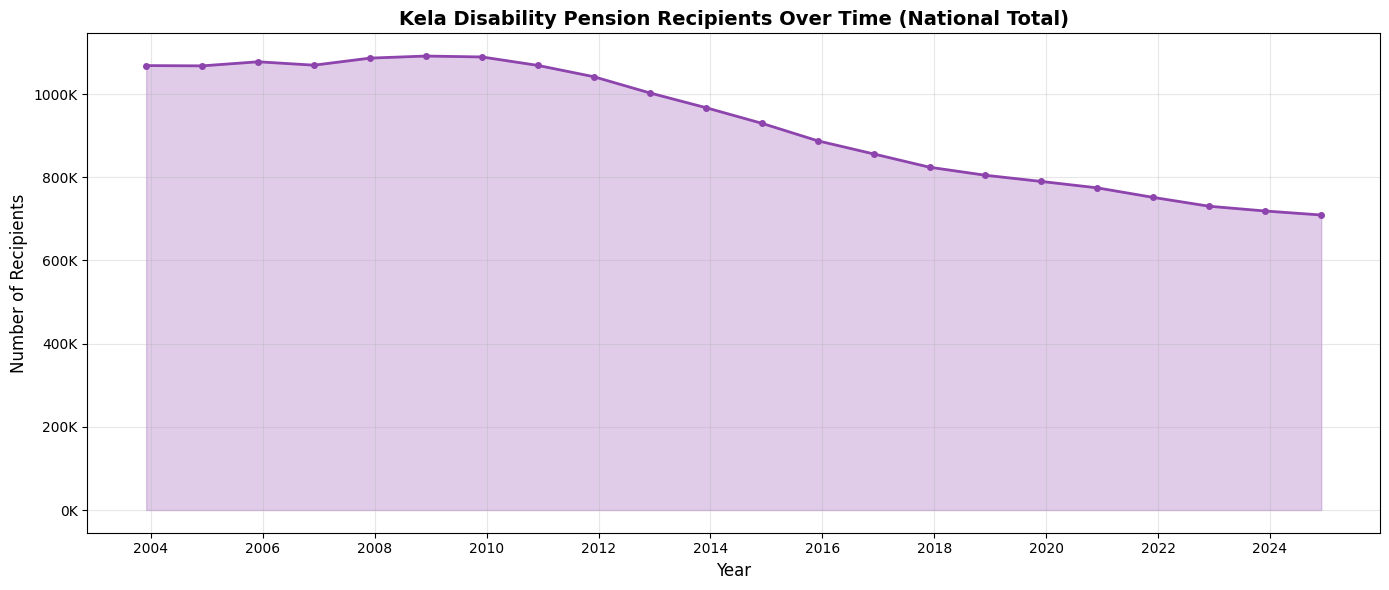

In [19]:
# Disability Pension Analysis - check for proper grouping
print("📊 AVAILABLE DIMENSIONS IN DISABILITY DATA:")
print(f"Columns: {list(kela_disability_df.columns)}")

# Check for national total vs summing municipalities
print(f"\nUnique locations (sample): {list(kela_disability_df['kunta_nimi'].unique()[:10])}")
print(f"Total municipalities: {kela_disability_df['kunta_nimi'].nunique()}")

# Check for disease groups
if 'sairausryhma' in kela_disability_df.columns:
    print(f"\nDisease groups (sairausryhma):")
    print(kela_disability_df['sairausryhma'].unique())

# CORRECT APPROACH: Filter to "Koko maa" (whole country) if available, OR use a total row
# to avoid summing all municipalities
if 'Koko maa' in kela_disability_df['kunta_nimi'].values:
    print("\n✅ Found 'Koko maa' (national total) - using that instead of summing")
    disability_national = kela_disability_df[kela_disability_df['kunta_nimi'] == 'Koko maa']
else:
    print("\n⚠️ No national total found - need to aggregate carefully")
    disability_national = kela_disability_df

# Group by month AND disease group to show breakdown
if 'sairausryhma' in disability_national.columns:
    disability_by_disease = disability_national.groupby(['vuosikuukausi', 'sairausryhma'])['saaja_lkm'].sum().reset_index()
    disability_by_disease = disability_by_disease.sort_values('vuosikuukausi')
    
    # Get last 24 months
    last_months = disability_by_disease['vuosikuukausi'].unique()[-24:]
    disability_by_disease = disability_by_disease[disability_by_disease['vuosikuukausi'].isin(last_months)]
    
    # Summary for latest month
    latest_month = disability_by_disease['vuosikuukausi'].max()
    latest_data = disability_by_disease[disability_by_disease['vuosikuukausi'] == latest_month]
    
    print(f"\n📊 Disability Pension by Disease Group ({latest_month}):")
    for _, row in latest_data.sort_values('saaja_lkm', ascending=False).iterrows():
        print(f"  {row['sairausryhma']}: {row['saaja_lkm']:,} recipients")
    
    # Get just the total row if available
    total_rows = latest_data[latest_data['sairausryhma'].str.contains('Yhteens|yhteens|Total', na=False, case=False)]
    if len(total_rows) > 0:
        print(f"\n✅ National total: {total_rows['saaja_lkm'].values[0]:,}")
    else:
        print(f"\n⚠️ No total row - sum may include overlapping categories!")

    # For time series, use only the total if available
    total_mask = disability_by_disease['sairausryhma'].str.contains('Yhteens|yhteens|Total', na=False, case=False)
    if total_mask.any():
        disability_monthly = disability_by_disease[total_mask].copy()
    else:
        # Fallback - sum but warn
        disability_monthly = disability_by_disease.groupby('vuosikuukausi')['saaja_lkm'].sum().reset_index()
        print("\n⚠️ Using sum of disease groups - may over-count!")
    
    disability_monthly['Date'] = pd.to_datetime(disability_monthly['vuosikuukausi'].astype(str), format='%Y%m')
    disability_monthly = disability_monthly.sort_values('Date')
    disability_monthly['Label'] = disability_monthly['Date'].dt.strftime('%Y-%m')
    disability_monthly.columns = ['Month', 'Disease', 'Recipients', 'Date', 'Label'] if 'sairausryhma' in disability_monthly.columns else ['Month', 'Recipients', 'Date', 'Label']
else:
    disability_monthly = disability_national.groupby('vuosikuukausi')['saaja_lkm'].sum().reset_index()
    disability_monthly['Date'] = pd.to_datetime(disability_monthly['vuosikuukausi'].astype(str), format='%Y%m')
    disability_monthly = disability_monthly.sort_values('Date')
    disability_monthly['Label'] = disability_monthly['Date'].dt.strftime('%Y-%m')
    disability_monthly.columns = ['Month', 'Recipients', 'Date', 'Label']

print("\nKELA DISABILITY PENSION - Monthly totals")
print("=" * 60)
print(f"Data range: {disability_monthly['Label'].min()} to {disability_monthly['Label'].max()}")
print(f"\nRecent months:")
display(disability_monthly[['Label', 'Recipients']].tail(12))

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))
ax.fill_between(disability_monthly['Date'], disability_monthly['Recipients'], alpha=0.3, color='#9b59b6')
ax.plot(disability_monthly['Date'], disability_monthly['Recipients'], marker='o', markersize=4, color='#8e44ad', linewidth=2)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Recipients', fontsize=12)
ax.set_title('Kela Disability Pension Recipients Over Time (National Total)', fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(2))
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Data Source 9: StatFin - Main Type of Activity (Labour Force)

In [20]:
# Fetch main activity data - employed, unemployed, outside labour force breakdown
activity_url = f"{STATFIN_URL}/tyokay/statfin_tyokay_pxt_115b.px"
response = requests.get(activity_url)
activity_meta = response.json()

print("Main Activity Table - Variables:")
for var in activity_meta['variables']:
    print(f"\n📊 {var['code']}: {var['text']}")
    for code, text in zip(var['values'][:10], var['valueTexts'][:10]):
        print(f"   - {code}: {text}")
    if len(var['values']) > 10:
        print(f"   ... and {len(var['values']) - 10} more")

Main Activity Table - Variables:

📊 Alue: Area
   - SSS: WHOLE COUNTRY
   - KU020: Akaa
   - KU005: Alajärvi
   - KU009: Alavieska
   - KU010: Alavus
   - KU016: Asikkala
   - KU018: Askola
   - KU019: Aura
   - KU035: Brändö
   - KU043: Eckerö
   ... and 299 more

📊 Pääasiallinen toiminta: Main type of activity
   - SSS: Total
   - 11+12: Labour force
   - 11: Employed
   - 12: Unemployed
   - 21-99: Persons outside the labour force
   - 21: 0-14 years old
   - 22: Students, pupils
   - 25: Conscripts, persons in non-military service
   - 24+29: Pensioners
   - 99: Other persons outside the labour force

📊 Sukupuoli: Sex
   - SSS: Total
   - 1: Males
   - 2: Females

📊 Ikä: Age
   - SSS: Total
   - 0-17: 0 - 17
   - 18-64: 18 - 64
   - 65-: 65 -

📊 Vuosi: Year
   - 1987: 1987
   - 1988: 1988
   - 1989: 1989
   - 1990: 1990
   - 1991: 1991
   - 1992: 1992
   - 1993: 1993
   - 1994: 1994
   - 1995: 1995
   - 1996: 1996
   ... and 28 more

📊 Tiedot: Information
   - vaesto: Population 31

MAIN TYPE OF ACTIVITY - Working Age (18-64) - 2024


,Activity,Count_2024
0,Total,3293886
1,Labour force,2694557
2,Employed,2374438
3,Unemployed,320119
4,Persons outside the labour force,599329
5,"Students, pupils",255178
6,Pensioners,166760
7,Other persons outside the labour force,169442


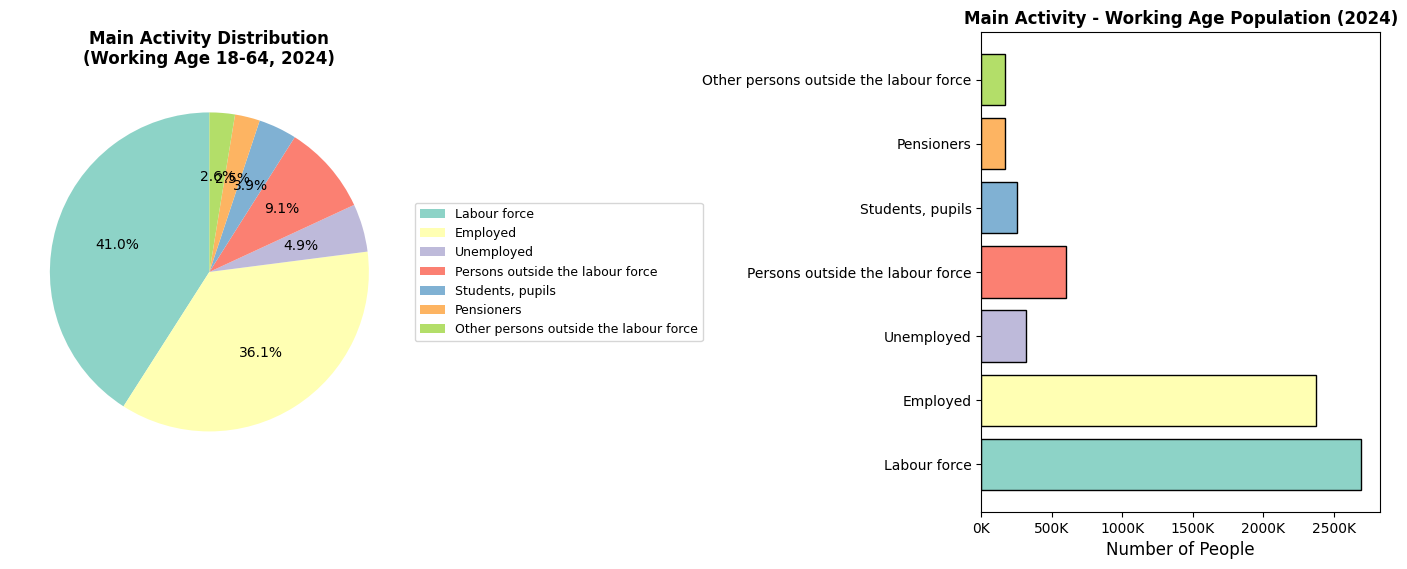

In [21]:
# Fetch main activity data - all categories, working age, latest year
years = [v for v in activity_meta['variables'] if v['code'] == 'Vuosi'][0]['values']
latest_year = years[-1]

activity_codes = ["SSS", "11+12", "11", "12", "21-99", "22", "24+29", "99"]

query = {
    "query": [
        {"code": "Alue", "selection": {"filter": "item", "values": ["SSS"]}},
        {"code": "Sukupuoli", "selection": {"filter": "item", "values": ["SSS"]}},
        {"code": "Ikä", "selection": {"filter": "item", "values": ["18-64"]}},  # Working age
        {"code": "Vuosi", "selection": {"filter": "item", "values": [latest_year]}},
        {"code": "Pääasiallinen toiminta", "selection": {"filter": "item", "values": activity_codes}},
    ],
    "response": {"format": "json-stat2"}
}

response = requests.post(activity_url, json=query)

if response.status_code == 200:
    activity_data = response.json()
    
    activity_dim = activity_data['dimension']['Pääasiallinen toiminta']
    activities = list(activity_dim['category']['label'].values())
    values = activity_data['value']
    
    activity_df = pd.DataFrame({'Activity': activities, f'Count_{latest_year}': values})
    print(f"MAIN TYPE OF ACTIVITY - Working Age (18-64) - {latest_year}")
    display(activity_df)
    
    # Visualization: Main Activity Breakdown
    # Filter out 'Total' for visualization
    vis_df = activity_df[activity_df['Activity'] != 'Total'].copy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Pie chart
    colors = plt.cm.Set3(range(len(vis_df)))
    wedges, texts, autotexts = ax1.pie(vis_df[f'Count_{latest_year}'], 
                                        labels=None, autopct='%1.1f%%', 
                                        colors=colors, startangle=90)
    ax1.legend(wedges, vis_df['Activity'], loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
    ax1.set_title(f'Main Activity Distribution\n(Working Age 18-64, {latest_year})', fontsize=12, fontweight='bold')
    
    # Horizontal bar chart
    bars = ax2.barh(vis_df['Activity'], vis_df[f'Count_{latest_year}'], color=colors, edgecolor='black')
    ax2.set_xlabel('Number of People', fontsize=12)
    ax2.set_title(f'Main Activity - Working Age Population ({latest_year})', fontsize=12, fontweight='bold')
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Error: {response.status_code}")
    print(response.text)

## Data Source 10: Part-time vs Full-time Employment (StatFin)
Shows underemployment - people working less than they want

In [22]:
# Explore Labour Force Survey for part-time employment
# Table: 137c - Employed by full/part-time work
lfs_tables_url = "https://pxdata.stat.fi/PxWeb/api/v1/en/StatFin/tyti/"
resp = requests.get(lfs_tables_url)
lfs_tables = resp.json()

# Find tables related to part-time
for t in lfs_tables:
    tid = t.get('id', '')
    txt = t.get('text', '')
    if 'part' in txt.lower() or 'full' in txt.lower() or 'time' in txt.lower():
        print(f"{tid}: {txt}")

statfin_tyti_pxt_13am.px: 13am -- Participation of young people (15-29) in education and the labour market by sex and age, 2009-2025
statfin_tyti_pxt_13aw.px: 13aw -- Employed persons and employees in part-time or full-time work by sex and age, 2009-2025
statfin_tyti_pxt_13gh.px: 13gh -- Employed persons and employees aged 15-74 in part-time or full-time work by sex, monthly data, 2009M01-2025M12
statfin_tyti_pxt_13lz.px: 13lz -- Employed persons and employees aged 15-74 in part-time or full-time work by sex, quarterly data, 2009Q1-2025Q4
statfin_tyti_pxt_14bp.px: 14bp -- Employed aged 15 to 74 by reason of part-time work and gender, quarterly data, 2021Q1-2025Q4
statfin_tyti_pxt_14bq.px: 14bq -- Employed aged 15 to 74 by reason of part-time work and gender, annual data, 2021-2025


In [23]:
# Explore part-time/full-time table structure
parttime_url = "https://pxdata.stat.fi/PxWeb/api/v1/en/StatFin/tyti/statfin_tyti_pxt_13aw.px"
resp = requests.get(parttime_url)
parttime_meta = resp.json()

print("Variables for part-time employment table:")
for var in parttime_meta['variables']:
    print(f"\n{var['code']}: {var['text']}")
    print(f"  Values ({len(var['values'])}): {var['values'][:8]}...")
    print(f"  Texts: {var['valueTexts'][:8]}...")

Variables for part-time employment table:

Vuosi: Year
  Values (17): ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']...
  Texts: ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']...

Sukupuoli: Sex
  Values (3): ['SSS', '1', '2']...
  Texts: ['Total', 'Males', 'Females']...

Ikäluokka: Age group
  Values (8): ['15-74', '15-64', '15-24', '25-34', '35-44', '45-54', '55-64', '65-74']...
  Texts: ['15 - 74', '15 - 64', '15 - 24', '25 - 34', '35 - 44', '45 - 54', '55 - 64', '65 - 74']...

Osa-aikatyö: Part-time employed
  Values (3): ['SSS', '1', '2']...
  Texts: ['Total', 'Full-time work', 'Part-time work']...

Tiedot: Information
  Values (2): ['Tyolliset', 'palkansaaja']...
  Texts: ['Employed, 1000 persons', 'Employees, 1000 persons']...


📊 Part-time vs Full-time Employment (15-64, 2025)
     Work Type  Employed
         Total   2495000
Full-time work   2043000
Part-time work    433000

Part-time rate: 17.4%


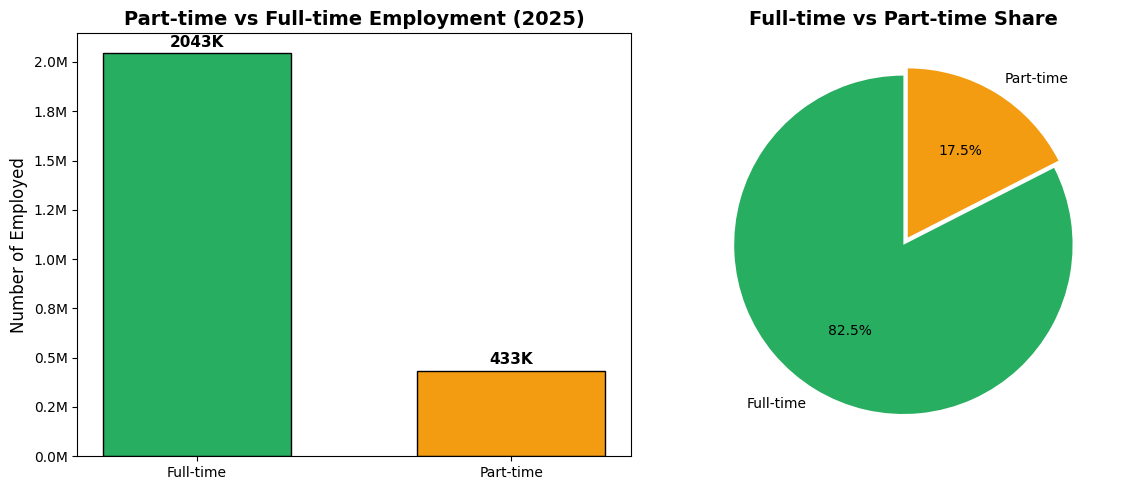

In [24]:
# Fetch part-time vs full-time employment data - working age (15-64), latest year
parttime_meta = requests.get(parttime_url).json()
parttime_year = [v for v in parttime_meta['variables'] if v['code'] == 'Vuosi'][0]['values'][-1]

parttime_query = {
    "query": [
        {"code": "Vuosi", "selection": {"filter": "item", "values": [parttime_year]}},
        {"code": "Sukupuoli", "selection": {"filter": "item", "values": ["SSS"]}},
        {"code": "Ikäluokka", "selection": {"filter": "item", "values": ["15-64"]}},
        {"code": "Osa-aikatyö", "selection": {"filter": "item", "values": ["SSS", "1", "2"]}},
        {"code": "Tiedot", "selection": {"filter": "item", "values": ["Tyolliset"]}}
    ],
    "response": {"format": "json-stat2"}
}

resp = requests.post(parttime_url, json=parttime_query)
data = resp.json()

# Parse data
values = data['value']
parttime_cats = data['dimension']['Osa-aikatyö']['category']['label']

parttime_df = pd.DataFrame([
    {"Work Type": parttime_cats[k], "Employed_1000": values[i]}
    for i, k in enumerate(parttime_cats.keys())
])

# Convert to actual numbers
parttime_df['Employed'] = parttime_df['Employed_1000'] * 1000

print(f"📊 Part-time vs Full-time Employment (15-64, {parttime_year})")
print("="*50)
print(parttime_df[['Work Type', 'Employed']].to_string(index=False))

# Calculate percentages
total = parttime_df[parttime_df['Work Type']=='Total']['Employed'].values[0]
parttime = parttime_df[parttime_df['Work Type']=='Part-time work']['Employed'].values[0]
fulltime = parttime_df[parttime_df['Work Type']=='Full-time work']['Employed'].values[0]
print(f"\nPart-time rate: {parttime/total*100:.1f}%")

# Visualization: Part-time vs Full-time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
work_types = ['Full-time', 'Part-time']
work_values = [fulltime, parttime]
colors = ['#27ae60', '#f39c12']
bars = ax1.bar(work_types, work_values, color=colors, edgecolor='black', width=0.6)
ax1.set_ylabel('Number of Employed', fontsize=12)
ax1.set_title(f'Part-time vs Full-time Employment ({parttime_year})', fontsize=14, fontweight='bold')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 20000,
             f'{height/1000:.0f}K', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
ax2.pie([fulltime, parttime], labels=['Full-time', 'Part-time'], autopct='%1.1f%%',
        colors=colors, explode=(0, 0.05), startangle=90)
ax2.set_title('Full-time vs Part-time Share', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Data Source 11: Reasons for Part-time Work (Underemployment)
Involuntary part-time = people who want full-time but can't find it

In [25]:
# Explore reasons for part-time work
reason_url = "https://pxdata.stat.fi/PxWeb/api/v1/en/StatFin/tyti/statfin_tyti_pxt_14bq.px"
resp = requests.get(reason_url)
reason_meta = resp.json()

print("Variables for part-time reasons:")
for var in reason_meta['variables']:
    print(f"\n{var['code']}: {var['text']}")
    print(f"  Values: {var['values']}")
    print(f"  Texts: {var['valueTexts']}")

Variables for part-time reasons:

Vuosi: Year
  Values: ['2021', '2022', '2023', '2024', '2025']
  Texts: ['2021', '2022', '2023', '2024', '2025']

Sukupuoli: Sex
  Values: ['SSS', '1', '2']
  Texts: ['Total', 'Males', 'Females']

Osa-aikatyön syy: Reason for part-time work
  Values: ['SS', '1', '2', '3', '4', '5']
  Texts: ['Part-time workers in total', 'Full-time work was not available', 'Studies', 'Takes care of own children or another relative', 'Health reasons', 'Works part-time for some other reason']

Tiedot: Information
  Values: ['Tyolliset', 'ossy_pros']
  Texts: ['Employed, 1000 persons', 'Percentage of employed working part-time']


📊 Reasons for Part-time Work (2025)
                                        Reason  Employed
                    Part-time workers in total    493000
              Full-time work was not available    132000
                                       Studies    128000
Takes care of own children or another relative     33000
                                Health reasons     38000
         Works part-time for some other reason    160000

⚠️ UNDEREMPLOYED (want full-time): 132,000


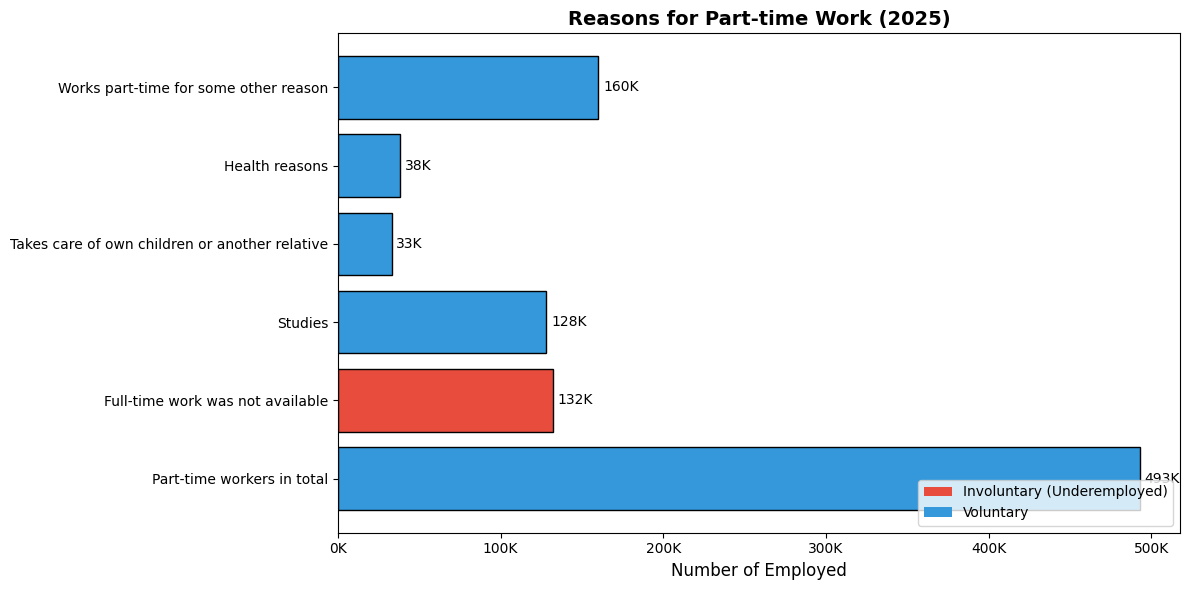

In [26]:
# Fetch reasons for part-time work - latest year available
reason_meta = requests.get(reason_url).json()
reason_year = [v for v in reason_meta['variables'] if v['code'] == 'Vuosi'][0]['values'][-1]

reason_query = {
    "query": [
        {"code": "Vuosi", "selection": {"filter": "item", "values": [reason_year]}},
        {"code": "Sukupuoli", "selection": {"filter": "item", "values": ["SSS"]}},
        {"code": "Osa-aikatyön syy", "selection": {"filter": "item", "values": ["SS", "1", "2", "3", "4", "5"]}},
        {"code": "Tiedot", "selection": {"filter": "item", "values": ["Tyolliset"]}}
    ],
    "response": {"format": "json-stat2"}
}

resp = requests.post(reason_url, json=reason_query)
data = resp.json()

values = data['value']
reasons = data['dimension']['Osa-aikatyön syy']['category']['label']

reason_df = pd.DataFrame([
    {"Reason": reasons[k], "Employed_1000": values[i]}
    for i, k in enumerate(reasons.keys())
])
reason_df['Employed'] = reason_df['Employed_1000'] * 1000

print(f"📊 Reasons for Part-time Work ({reason_year})")
print("="*50)
print(reason_df[['Reason', 'Employed']].to_string(index=False))

# Key metric: involuntary part-time
involuntary = reason_df[reason_df['Reason']=='Full-time work was not available']['Employed'].values[0]
print(f"\n⚠️ UNDEREMPLOYED (want full-time): {involuntary:,.0f}")

# Visualization: Reasons for Part-time Work
vis_df = reason_df[reason_df['Reason'] != 'Total'].copy()
fig, ax = plt.subplots(figsize=(12, 6))

# Color involuntary differently
colors = ['#e74c3c' if 'not available' in r else '#3498db' for r in vis_df['Reason']]
bars = ax.barh(vis_df['Reason'], vis_df['Employed'], color=colors, edgecolor='black')
ax.set_xlabel('Number of Employed', fontsize=12)
ax.set_title(f'Reasons for Part-time Work ({reason_year})', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

for bar in bars:
    width = bar.get_width()
    ax.text(width + 3000, bar.get_y() + bar.get_height()/2,
            f'{width/1000:.0f}K', va='center', fontsize=10)

# Add legend for involuntary
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', label='Involuntary (Underemployed)'),
                   Patch(facecolor='#3498db', label='Voluntary')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

## Data Source 12: Employment Contract Types
Permanent vs temporary (fixed-term) employment - job security indicator

In [27]:
# Explore contract types table
contract_url = "https://pxdata.stat.fi/PxWeb/api/v1/en/StatFin/tyti/statfin_tyti_pxt_12bt.px"
resp = requests.get(contract_url)
contract_meta = resp.json()

print("Variables for contract types:")
for var in contract_meta['variables']:
    print(f"\n{var['code']}: {var['text']}")
    print(f"  Values: {var['values'][:10]}")
    print(f"  Texts: {var['valueTexts'][:10]}")

Variables for contract types:

Vuosi: Year
  Values: ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
  Texts: ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

Sukupuoli: Sex
  Values: ['SSS', '1', '2']
  Texts: ['Total', 'Males', 'Females']

Työnantajasektori: Employer sector
  Values: ['*', '1', '2', '3', 'JS']
  Texts: ['Employer sector total', 'Central government', 'Local government (incl. wellbeing services county administration)', 'Private sector', 'Public sector']

Tiedot: Information
  Values: ['Palkansaajat_yht', 'Jva_tyo', 'Ma_tyo', 'Jva_tyo_pros', 'Ma_tyo_pros']
  Texts: ['Employees total, 1000 persons', 'Employees, permanent work total, 1000 persons', 'Employees, temporary (fixed-term) work total, 1000 persons', 'Permanent work total, proportion of employees, %', 'Temporary (fixed-term) work total, proportion of employees, %']


📊 Employment Contract Types (2025)
Type                   Employees total, 1000 persons  Employees, permanent work total, 1000 persons  Employees, temporary (fixed-term) work total, 1000 persons
Sector                                                                                                                                                         
Employer sector total                        2276000                                        1929000                                                      346000
Private sector                               1597000                                        1405000                                                      192000
Public sector                                 665000                                         518000                                                      147000

⚠️ Total temporary workers: 685,000


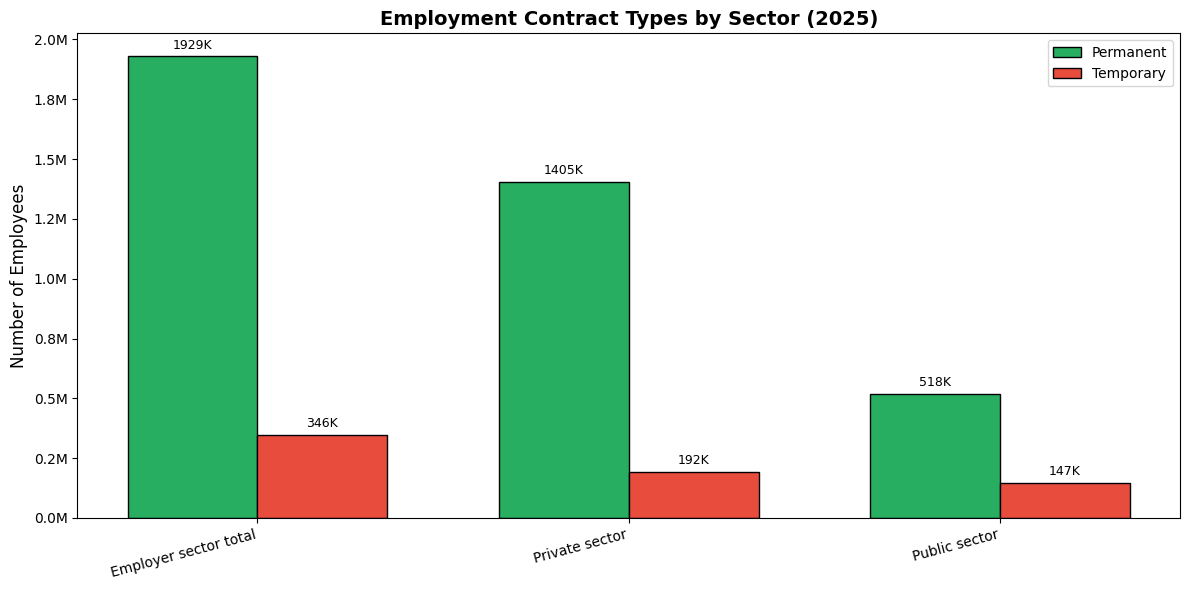

In [28]:
# Fetch permanent vs temporary by sector - latest year available
contract_meta = requests.get(contract_url).json()
contract_year = [v for v in contract_meta['variables'] if v['code'] == 'Vuosi'][0]['values'][-1]

contract_query = {
    "query": [
        {"code": "Vuosi", "selection": {"filter": "item", "values": [contract_year]}},
        {"code": "Sukupuoli", "selection": {"filter": "item", "values": ["SSS"]}},
        {"code": "Työnantajasektori", "selection": {"filter": "item", "values": ["*", "3", "JS"]}},  # Total, Private, Public
        {"code": "Tiedot", "selection": {"filter": "item", "values": ["Palkansaajat_yht", "Jva_tyo", "Ma_tyo"]}}
    ],
    "response": {"format": "json-stat2"}
}

resp = requests.post(contract_url, json=contract_query)
data = resp.json()

values = data['value']
sectors = list(data['dimension']['Työnantajasektori']['category']['label'].values())
info_types = list(data['dimension']['Tiedot']['category']['label'].values())

# Parse into DataFrame - values are in order: sector × info
results = []
idx = 0
for sector in sectors:
    for info in info_types:
        results.append({
            'Sector': sector,
            'Type': info,
            'Value_1000': values[idx]
        })
        idx += 1

contract_df = pd.DataFrame(results)
contract_df['Value'] = contract_df['Value_1000'] * 1000

# Pivot for display
pivot = contract_df.pivot(index='Sector', columns='Type', values='Value')
print(f"📊 Employment Contract Types ({contract_year})")
print("="*60)
print(pivot.round(0).to_string())

# Key metrics (computed)
total_temp = contract_df[contract_df['Type'].str.contains('temporary', case=False, na=False)]['Value'].sum()
total_perm = contract_df[contract_df['Type'].str.contains('permanent', case=False, na=False)]['Value'].sum()
print(f"\n⚠️ Total temporary workers: {total_temp:,.0f}")

# Visualization: Contract Types by Sector
import numpy as np
fig, ax = plt.subplots(figsize=(12, 6))

sectors_vis = pivot.index.tolist()
x = np.arange(len(sectors_vis))
width = 0.35

# Get column names dynamically
perm_col = [c for c in pivot.columns if 'permanent' in str(c).lower()]
temp_col = [c for c in pivot.columns if 'temporary' in str(c).lower()]

permanent_vals = [pivot.loc[s, perm_col[0]] if perm_col else 0 for s in sectors_vis]
temporary_vals = [pivot.loc[s, temp_col[0]] if temp_col else 0 for s in sectors_vis]

bars1 = ax.bar(x - width/2, permanent_vals, width, label='Permanent', color='#27ae60', edgecolor='black')
bars2 = ax.bar(x + width/2, temporary_vals, width, label='Temporary', color='#e74c3c', edgecolor='black')

ax.set_ylabel('Number of Employees', fontsize=12)
ax.set_title(f'Employment Contract Types by Sector ({contract_year})', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(sectors_vis, rotation=15, ha='right')
ax.legend()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

for i, (p, t) in enumerate(zip(permanent_vals, temporary_vals)):
    ax.text(x[i] - width/2, p + 20000, f'{p/1000:.0f}K', ha='center', va='bottom', fontsize=9)
    ax.text(x[i] + width/2, t + 20000, f'{t/1000:.0f}K', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Data Source 13: Layoffs & Dismissals (TE-office)
People notified of upcoming job loss or temporarily laid off

In [29]:
# Look for layoff/dismissal data in employment services
layoff_url = "https://pxdata.stat.fi/PxWeb/api/v1/en/StatFin/tyonv/"
resp = requests.get(layoff_url)
tables = resp.json()

print("Looking for layoff-related tables:")
for t in tables:
    txt = t.get('text', '').lower()
    if 'layoff' in txt or 'laid' in txt or 'dismissal' in txt or 'redundan' in txt:
        print(f"  {t['id']}: {t['text']}")

Looking for layoff-related tables:
  statfin_tyonv_pxt_12tj.px: 12tj -- Unemployed, fully laid off and on reduced working week by occupation at the end of the month (1271), 2008M01-2025M12


In [30]:
# Explore layoff table
layoff_table_url = "https://pxdata.stat.fi/PxWeb/api/v1/en/StatFin/tyonv/statfin_tyonv_pxt_12tj.px"
resp = requests.get(layoff_table_url)
layoff_meta = resp.json()

print("Variables for layoff data:")
for var in layoff_meta['variables']:
    print(f"\n{var['code']}: {var['text']}")
    print(f"  Values ({len(var['values'])}): {var['values'][:8]}")
    print(f"  Texts: {var['valueTexts'][:8]}")

Variables for layoff data:

Alue: Region
  Values (421): ['SSS', 'KU020', 'KU005', 'KU009', 'KU010', 'KU016', 'KU018', 'KU019']
  Texts: ['WHOLE COUNTRY', 'Akaa', 'Alajärvi', 'Alavieska', 'Alavus', 'Asikkala', 'Askola', 'Aura']

Ammattiryhmä: Occupation
  Values (434): ['SSS', '1111', '1112', '1114', '1120', '1211', '1212', '1213']
  Texts: ['SSS Total', '1111 Legislators', '1112 Senior central government officials', '1114 Senior officials of special-interest organiäations', '1120 Managing directors and chief executives', '1211 Finance managers', '1212 Human resource managers', '1213 Policy and planning managers']

Työllisyyskoodi: Työllisyyskoodi
  Values (3): ['02', '03', '04']
  Texts: ['Työtön', 'Lomautettu', 'Lyhennetyllä työvkolla']

Kuukausi: Month
  Values (216): ['2008M01', '2008M02', '2008M03', '2008M04', '2008M05', '2008M06', '2008M07', '2008M08']
  Texts: ['2008M01', '2008M02', '2008M03', '2008M04', '2008M05', '2008M06', '2008M07', '2008M08']

Tiedot: Information
  Values (

📊 Layoffs & Reduced Hours (2025M12)
           Status_EN  Count
          Unemployed 319663
    Laid off (fully)  31823
Reduced working week  11132

⚠️ Currently laid off or reduced hours: 42,955


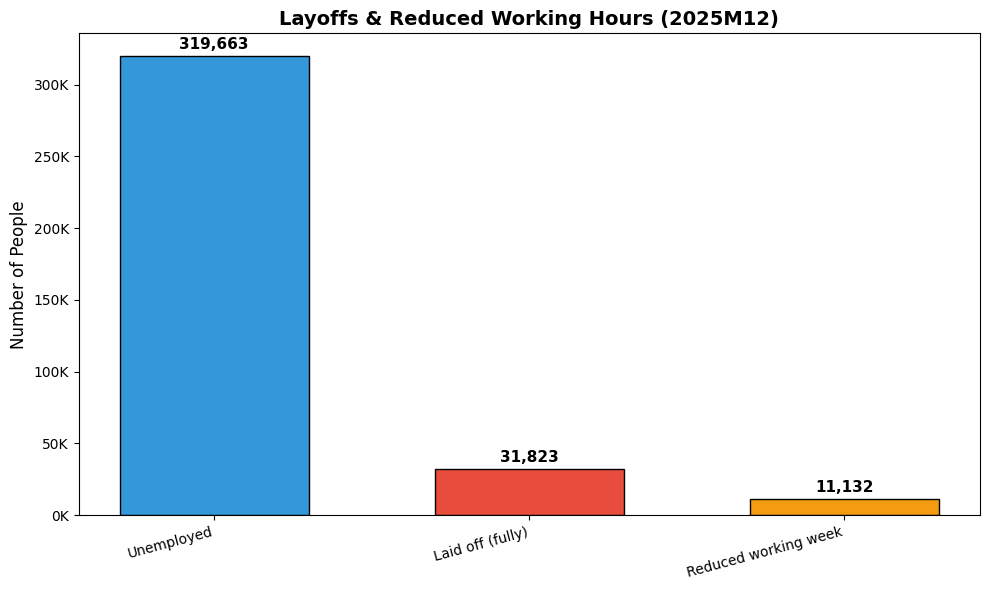

In [31]:
# Fetch layoff data - latest month, whole country, all occupations
layoff_month = [v for v in layoff_meta['variables'] if v['code'] == 'Kuukausi'][0]['values'][-1]

layoff_query = {
    "query": [
        {"code": "Alue", "selection": {"filter": "item", "values": ["SSS"]}},
        {"code": "Ammattiryhmä", "selection": {"filter": "item", "values": ["SSS"]}},
        {"code": "Työllisyyskoodi", "selection": {"filter": "item", "values": ["02", "03", "04"]}},
        {"code": "Kuukausi", "selection": {"filter": "item", "values": [layoff_month]}}
    ],
    "response": {"format": "json-stat2"}
}

resp = requests.post(layoff_table_url, json=layoff_query)
data = resp.json()

values = data['value']
codes = list(data['dimension']['Työllisyyskoodi']['category']['label'].values())

layoff_df = pd.DataFrame([
    {"Status": codes[i], "Count": values[i]}
    for i in range(len(codes))
])

# Translate status codes
status_map = {
    'Työtön': 'Unemployed',
    'Lomautettu': 'Laid off (fully)',
    'Lyhennetyllä työvkolla': 'Reduced working week'
}
layoff_df['Status_EN'] = layoff_df['Status'].map(status_map)

print(f"📊 Layoffs & Reduced Hours ({layoff_month})")
print("="*50)
print(layoff_df[['Status_EN', 'Count']].to_string(index=False))

laid_off = layoff_df[layoff_df['Status']=='Lomautettu']['Count'].values[0]
reduced = layoff_df[layoff_df['Status']=='Lyhennetyllä työvkolla']['Count'].values[0]
print(f"\n⚠️ Currently laid off or reduced hours: {laid_off + reduced:,.0f}")

# Visualization: Layoffs and Reduced Hours
fig, ax = plt.subplots(figsize=(10, 6))

vis_df = layoff_df[layoff_df['Status_EN'].notna()].copy()
colors = ['#3498db', '#e74c3c', '#f39c12']
bars = ax.bar(vis_df['Status_EN'], vis_df['Count'], color=colors, edgecolor='black', width=0.6)

ax.set_ylabel('Number of People', fontsize=12)
ax.set_title(f'Layoffs & Reduced Working Hours ({layoff_month})', fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 3000,
            f'{height:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## Data Catalog Summary

What we have fetched so far:

In [32]:
# ============================================================
# COMPLETE DATA CATALOG - ALL 13 SOURCES
# ============================================================

print("="*70)
print("DATA CATALOG - ALL SOURCES (derived from fetched data)")
print("="*70)

# Derive years/months from the data we actually fetched
employer_employed_cols = [c for c in employer_df.columns if str(c).startswith('Employed_')]
employer_year = employer_employed_cols[0].split('_', 1)[1] if employer_employed_cols else "?"
pop_year_label = str(pop_year) if 'pop_year' in globals() else "?"
es_month_label = str(latest_month) if 'latest_month' in globals() else "?"
layoff_month_label = str(layoff_month) if 'layoff_month' in globals() else "?"
activity_count_cols = [c for c in activity_df.columns if str(c).startswith('Count_')]
activity_year = activity_count_cols[0].split('_', 1)[1] if activity_count_cols else "?"
parttime_year_label = str(parttime_year) if 'parttime_year' in globals() else "?"

print(f"\n📊 1. EMPLOYER SECTOR (StatFin {employer_year})")
display(employer_df)

print(f"\n📊 2. POPULATION BY AGE (StatFin {pop_year_label})")
display(pop_df.head(10))

print(f"\n📊 3. UNEMPLOYED JOBSEEKERS (StatFin {es_month_label})")
display(es_df)

print("\n📊 4. KELA UNEMPLOYMENT BENEFITS")
display(kela_unemp_df.tail(3))

print("\n📊 5. KELA HOUSING ALLOWANCE")
display(kela_housing_df.tail(3))

print("\n📊 6. KELA BASIC INCOME SUPPORT")
display(kela_income_df.tail(3))

print("\n📊 7. EUROSTAT UNEMPLOYMENT RATES")
display(eurostat_df.head(10))

print("\n📊 8. KELA DISABILITY PENSION")
display(kela_disability_df.tail(3))

print(f"\n📊 9. MAIN TYPE OF ACTIVITY - Working Age 18-64 ({activity_year})")
display(activity_df)

print(f"\n📊 10. PART-TIME vs FULL-TIME EMPLOYMENT ({parttime_year_label})")
display(parttime_df[['Work Type', 'Employed']])

print("\n📊 11. REASONS FOR PART-TIME WORK")
display(reason_df[['Reason', 'Employed']])

print("\n📊 12. EMPLOYMENT CONTRACT TYPES")
display(pivot.round(0))

print(f"\n📊 13. LAYOFFS & REDUCED HOURS ({layoff_month_label})")
display(layoff_df[['Status_EN', 'Count']])

# ------------------------------------------------------------
# Data-driven key findings (no hardcoded result numbers)
# ------------------------------------------------------------
def _first_col(df, prefix: str):
    cols = [c for c in df.columns if str(c).startswith(prefix)]
    return cols[0] if cols else None

activity_count_col = _first_col(activity_df, 'Count_')
employer_employed_col = _first_col(employer_df, 'Employed_')

working_age_pop = activity_df.loc[activity_df['Activity'] == 'Total', activity_count_col].values[0]
employed_total = activity_df.loc[activity_df['Activity'] == 'Employed', activity_count_col].values[0]
unemployed_official = activity_df.loc[activity_df['Activity'] == 'Unemployed', activity_count_col].values[0]
outside_labour_force = activity_df.loc[activity_df['Activity'] == 'Persons outside the labour force', activity_count_col].values[0]

private_sector = employer_df.loc[employer_df['Sector'] == 'Private sector', employer_employed_col].values[0]
state_sector = employer_df.loc[employer_df['Sector'] == 'State', employer_employed_col].values[0]
local_govt = employer_df.loc[employer_df['Sector'] == 'Local government', employer_employed_col].values[0]
state_companies = employer_df.loc[employer_df['Sector'] == 'State-controlled companies', employer_employed_col].values[0]
public_sector_total = state_sector + local_govt + state_companies

part_time_total = parttime_df.loc[parttime_df['Work Type'] == 'Part-time work', 'Employed'].values[0]
underemployed = reason_df.loc[reason_df['Reason'] == 'Full-time work was not available', 'Employed'].values[0]

laid_off_count = layoff_df.loc[layoff_df['Status'] == 'Lomautettu', 'Count'].values[0]
reduced_hours = layoff_df.loc[layoff_df['Status'] == 'Lyhennetyllä työvkolla', 'Count'].values[0]

# Temporary contracts from contract pivot (Total row)
temp_cols = [c for c in pivot.columns if 'temporary' in str(c).lower()]
sector_total = next((s for s in pivot.index if str(s).lower() == 'total'), pivot.index[0])
temporary_contracts = pivot.loc[sector_total, temp_cols[0]] if temp_cols else float('nan')

# Latest Kela totals (where possible)
kela_unemp_latest = kela_monthly.iloc[-1] if 'kela_monthly' in globals() and len(kela_monthly) else None
basic_income_latest = income_monthly.iloc[-1] if 'income_monthly' in globals() and len(income_monthly) else None
disability_latest = disability_monthly.iloc[-1] if 'disability_monthly' in globals() and len(disability_monthly) else None

print("\n" + "="*70)
print("KEY FINDINGS FOR REAL EMPLOYMENT INDEX (computed)")
print("="*70)
print(f"Working age population (18-64):     {working_age_pop:>12,}  (year {activity_year})")
print(f"Employed (official):                {employed_total:>12,}  ({employed_total/working_age_pop*100:>4.1f}%)")
print(f"Unemployed (official):              {unemployed_official:>12,}  ({unemployed_official/working_age_pop*100:>4.1f}%)")
print(f"Outside labour force:               {outside_labour_force:>12,}")
print()
print(f"Private sector employed:            {private_sector:>12,}  ({private_sector/employed_total*100:>4.1f}% of employed)")
print(f"Public sector employed (state+local+SOEs): {public_sector_total:>8,}  ({public_sector_total/employed_total*100:>4.1f}% of employed)")
print()
print(f"Part-time workers:                  {part_time_total:>12,}")
print(f"Underemployed (want full-time):     {underemployed:>12,}")
print(f"Temporary contracts (total):        {temporary_contracts:>12,.0f}")
print(f"Laid off / reduced hours (total):   {(laid_off_count + reduced_hours):>12,}")
print()
if kela_unemp_latest is not None:
    print(f"Kela unemployment benefits (latest): {int(kela_unemp_latest['Recipients']):>11,}  (month {kela_unemp_latest['Month']})")
if basic_income_latest is not None and 'Label' in basic_income_latest:
    print(f"Basic income support (latest):       {int(basic_income_latest['Recipients']):>11,}  (month {basic_income_latest['Label']})")
elif basic_income_latest is not None:
    print(f"Basic income support (latest):       {int(basic_income_latest['Recipients']):>11,}")
if disability_latest is not None and 'Label' in disability_latest:
    print(f"Disability pension (latest):         {int(disability_latest['Recipients']):>11,}  (month {disability_latest['Label']})")
print("="*70)

DATA CATALOG - ALL SOURCES (derived from fetched data)

📊 1. EMPLOYER SECTOR (StatFin 2023)


,Sector,Employed_2023
0,Total,2417365
1,Private sector,1432298
2,State,137171
3,Local government,543976
4,State-controlled companies,53708



📊 2. POPULATION BY AGE (StatFin 2024)


,Age,Population
0,Total,5635971
1,0,43745
2,1,44025
3,2,46235
4,3,51428
5,4,48791
6,5,48232
7,6,50651
8,7,53711
9,8,56591



📊 3. UNEMPLOYED JOBSEEKERS (StatFin nan)


,Measure,Count
0,Unemployed jobseekers on calculation date (num...,351486
1,Vacancies on end-of-month calculation date (nu...,29320



📊 4. KELA UNEMPLOYMENT BENEFITS


,aikatyyppi,kuukausi_nro,vuosikuukausi,vuosi,kunta_nro,kunta_nimi,ikaryhma,sukupuoli,etuus,korvausperuste,korvauslaji,saaja_lkm
779359,Kuukausi,9,202509,2025,905,Vaasa,Tieto puuttuu,Tuntematon,TyÃ¶markkinatuki,-Omaehtoinen opiskelu,-Soviteltu tuki,8
779360,Kuukausi,9,202509,2025,895,Uusikaupunki,Tieto puuttuu,Tuntematon,TyÃ¶markkinatuki,-Omaehtoinen opiskelu,-Soviteltu tuki,12
779361,Kuukausi,9,202509,2025,893,Uusikaarlepyy,Tieto puuttuu,Tuntematon,TyÃ¶markkinatuki,-Omaehtoinen opiskelu,-Soviteltu tuki,3



📊 5. KELA HOUSING ALLOWANCE


,aikatyyppi,kuukausi_nro,vuosikuukausi,vuosi,kunta_nro,kunta_nimi,ikaryhma,ruokakuntatyyppi,hallintamuoto,elamantilanne,maksettu_eur
2017881,Kuukausi,9,202509,2025,10,Alavus,30-34,-Yhden huoltajan perheet,YhteensÃ¤,TyÃ¶ssÃ¤ olevat ruokakunnat,1272.95
2017882,Kuukausi,9,202509,2025,5,AlajÃ¤rvi,30-34,-Yhden huoltajan perheet,YhteensÃ¤,TyÃ¶ssÃ¤ olevat ruokakunnat,702.03
2017883,Kuukausi,9,202509,2025,992,ÃÃ¤nekoski,25-29,-Yhden huoltajan perheet,YhteensÃ¤,TyÃ¶ssÃ¤ olevat ruokakunnat,646.80



📊 6. KELA BASIC INCOME SUPPORT


,aikatyyppi,kuukausi_nro,vuosikuukausi,vuosi,kunta_nro,kunta_nimi,ikaryhma,saaja_lkm
241057,VuosikertymÃ¤,12,201712,2017,216,Kannonkoski,Tieto puuttuu,3
241058,VuosikertymÃ¤,12,201712,2017,217,Kannus,0-17,84
241059,VuosikertymÃ¤,12,201712,2017,217,Kannus,18-24,48



📊 7. EUROSTAT UNEMPLOYMENT RATES


,Country,Country_code,Time,Unemployment_rate
0,Austria,AT,1994-01,5.5
1,Austria,AT,1994-02,5.5
2,Austria,AT,1994-03,5.4
3,Austria,AT,1994-04,5.6
4,Austria,AT,1994-05,5.6
5,Austria,AT,1994-06,5.0
6,Austria,AT,1994-07,4.8
7,Austria,AT,1994-08,4.9
8,Austria,AT,1994-09,5.0
9,Austria,AT,1994-10,5.5



📊 8. KELA DISABILITY PENSION


,aikatyyppi,kuukausi_nro,vuosikuukausi,vuosi,kunta_nro,kunta_nimi,ikaryhma,sukupuoli,asuinmaa,sairauspaaryhma,saaja_lkm
858889,Kuukausi,12,200612,2006,978,978,55-59,Mies,Suomi,YhteensÃ¤,16
858890,Kuukausi,12,200612,2006,978,978,55-59,Mies,Suomi,F00-F99 Mielenterveyden ja kÃ¤yttÃ¤ytymisen hÃ...,9
858891,Kuukausi,12,200612,2006,978,978,55-59,Nainen,YhteensÃ¤,YhteensÃ¤,17



📊 9. MAIN TYPE OF ACTIVITY - Working Age 18-64 (2024)


,Activity,Count_2024
0,Total,3293886
1,Labour force,2694557
2,Employed,2374438
3,Unemployed,320119
4,Persons outside the labour force,599329
5,"Students, pupils",255178
6,Pensioners,166760
7,Other persons outside the labour force,169442



📊 10. PART-TIME vs FULL-TIME EMPLOYMENT (2025)


,Work Type,Employed
0,Total,2495000
1,Full-time work,2043000
2,Part-time work,433000



📊 11. REASONS FOR PART-TIME WORK


,Reason,Employed
0,Part-time workers in total,493000
1,Full-time work was not available,132000
2,Studies,128000
3,Takes care of own children or another relative,33000
4,Health reasons,38000
5,Works part-time for some other reason,160000



📊 12. EMPLOYMENT CONTRACT TYPES


Type,"Employees total, 1000 persons","Employees, permanent work total, 1000 persons","Employees, temporary (fixed-term) work total, 1000 persons"
Sector,,,
Employer sector total,2276000,1929000,346000
Private sector,1597000,1405000,192000
Public sector,665000,518000,147000



📊 13. LAYOFFS & REDUCED HOURS (2025M12)


,Status_EN,Count
0,Unemployed,319663
1,Laid off (fully),31823
2,Reduced working week,11132



KEY FINDINGS FOR REAL EMPLOYMENT INDEX (computed)
Working age population (18-64):        3,293,886  (year 2024)
Employed (official):                   2,374,438  (72.1%)
Unemployed (official):                   320,119  ( 9.7%)
Outside labour force:                    599,329

Private sector employed:               1,432,298  (60.3% of employed)
Public sector employed (state+local+SOEs):  734,855  (30.9% of employed)

Part-time workers:                       433,000
Underemployed (want full-time):          132,000
Temporary contracts (total):             346,000
Laid off / reduced hours (total):         42,955

Kela unemployment benefits (latest):   1,058,768  (month 202509)
Basic income support (latest):           365,029
Disability pension (latest):             709,324  (month 2024-12)


# REAL EMPLOYMENT INDEX - CALCULATIONS

## Methodology
The Real Employment Index separates truly productive private sector employment from:
1. **Public sector employment** (funded by taxes)
2. **Hidden unemployment** (receiving benefits but not counted as unemployed)
3. **Underemployment** (part-time involuntary)
4. **Precarious employment** (temporary contracts)

In [33]:
# ============================================================
# STEP 1: Extract Key Numbers from DataFrames (data-driven)
# ============================================================

def _first_col(df, prefix: str):
    cols = [c for c in df.columns if str(c).startswith(prefix)]
    return cols[0] if cols else None

# Activity year/column (no hardcoded Count_2024)
activity_count_col = _first_col(activity_df, 'Count_')
if activity_count_col is None:
    raise ValueError("activity_df is missing a Count_... column")
activity_year = activity_count_col.split('_', 1)[1]

# Working age population (18-64)
working_age_pop = activity_df.loc[activity_df['Activity'] == 'Total', activity_count_col].values[0]

# Employment breakdown from activity data
employed_total = activity_df.loc[activity_df['Activity'] == 'Employed', activity_count_col].values[0]
unemployed_official = activity_df.loc[activity_df['Activity'] == 'Unemployed', activity_count_col].values[0]
outside_labour_force = activity_df.loc[activity_df['Activity'] == 'Persons outside the labour force', activity_count_col].values[0]

# Employer sector breakdown (no hardcoded Employed_2023)
employer_employed_col = _first_col(employer_df, 'Employed_')
if employer_employed_col is None:
    raise ValueError("employer_df is missing an Employed_... column")
employer_year = employer_employed_col.split('_', 1)[1]

private_sector = employer_df.loc[employer_df['Sector'] == 'Private sector', employer_employed_col].values[0]
state_sector = employer_df.loc[employer_df['Sector'] == 'State', employer_employed_col].values[0]
local_govt = employer_df.loc[employer_df['Sector'] == 'Local government', employer_employed_col].values[0]
state_companies = employer_df.loc[employer_df['Sector'] == 'State-controlled companies', employer_employed_col].values[0]
public_sector_total = state_sector + local_govt + state_companies

# Job quality issues
part_time_total = parttime_df.loc[parttime_df['Work Type'] == 'Part-time work', 'Employed'].values[0]
underemployed = reason_df.loc[reason_df['Reason'] == 'Full-time work was not available', 'Employed'].values[0]

# Temporary contracts (derive from contract pivot; no literal 370000)
temp_cols = [c for c in pivot.columns if 'temporary' in str(c).lower()]
sector_total = next((s for s in pivot.index if str(s).lower() == 'total'), pivot.index[0])
temporary_contracts = pivot.loc[sector_total, temp_cols[0]] if temp_cols else float('nan')
if pd.isna(temporary_contracts):
    temp_mask = contract_df['Type'].str.contains('temporary', case=False, na=False)
    sector_mask = contract_df['Sector'].str.lower().eq('total')
    if (temp_mask & sector_mask).any():
        temporary_contracts = contract_df.loc[temp_mask & sector_mask, 'Value'].sum()

# Layoffs
laid_off_count = layoff_df.loc[layoff_df['Status'] == 'Lomautettu', 'Count'].values[0]
reduced_hours = layoff_df.loc[layoff_df['Status'] == 'Lyhennetyllä työvkolla', 'Count'].values[0]

print("="*70)
print("KEY EMPLOYMENT FIGURES EXTRACTED")
print("="*70)
print(f"""
POPULATION (18-64):                    {working_age_pop:>12,}  (year {activity_year})

OFFICIAL EMPLOYMENT STATUS:
  Employed:                            {employed_total:>12,}
  Unemployed:                          {unemployed_official:>12,}
  Outside labour force:                {outside_labour_force:>12,}

EMPLOYER SECTOR (year {employer_year}):
  Private sector:                      {private_sector:>12,}
  State:                               {state_sector:>12,}
  Local government:                    {local_govt:>12,}
  State-controlled companies:          {state_companies:>12,}
  PUBLIC SECTOR TOTAL:                 {public_sector_total:>12,}

JOB QUALITY ISSUES:
  Part-time workers:                   {part_time_total:>12,}
  Underemployed (involuntary PT):      {underemployed:>12,}
  Temporary contracts:                 {temporary_contracts:>12,.0f}

LAYOFFS:
  Fully laid off:                      {laid_off_count:>12,}
  Reduced working week:                {reduced_hours:>12,}
""")

KEY EMPLOYMENT FIGURES EXTRACTED

POPULATION (18-64):                       3,293,886  (year 2024)

OFFICIAL EMPLOYMENT STATUS:
  Employed:                               2,374,438
  Unemployed:                               320,119
  Outside labour force:                     599,329

EMPLOYER SECTOR (year 2023):
  Private sector:                         1,432,298
  State:                                    137,171
  Local government:                         543,976
  State-controlled companies:                53,708
  PUBLIC SECTOR TOTAL:                      734,855

JOB QUALITY ISSUES:
  Part-time workers:                        433,000
  Underemployed (involuntary PT):           132,000
  Temporary contracts:                      346,000

LAYOFFS:
  Fully laid off:                            31,823
  Reduced working week:                      11,132



In [34]:
# ============================================================
# STEP 2: CALCULATE REAL EMPLOYMENT INDEX
# ============================================================

if 'activity_count_col' not in globals():
    activity_count_col = [c for c in activity_df.columns if str(c).startswith('Count_')][0]

# --- REAL UNEMPLOYMENT CALCULATION ---
# Official unemployment only counts those actively seeking AND available
# But many others are effectively unemployed:
real_unemployment = {
    'Official unemployed': unemployed_official,
    'Laid off (full)': laid_off_count,
    'Reduced working week': reduced_hours,
    'Underemployed (want full-time)': underemployed,
    'Outside labour force - Other': activity_df.loc[activity_df['Activity'] == 'Other persons outside the labour force', activity_count_col].values[0],
    'Early pensioners (18-64)': activity_df.loc[activity_df['Activity'] == 'Pensioners', activity_count_col].values[0],
}

real_unemployment_total = sum(real_unemployment.values())

print("="*70)
print("REAL UNEMPLOYMENT CALCULATION")
print("="*70)
print("\nComponents of real unemployment:")
for component, value in real_unemployment.items():
    print(f"  {component:<40} {value:>10,}")
print("-"*55)
print(f"  {'REAL UNEMPLOYMENT TOTAL':<40} {real_unemployment_total:>10,}")

# Calculate rates
official_unemp_rate = unemployed_official / working_age_pop * 100
real_unemp_rate = real_unemployment_total / working_age_pop * 100

print(f"\n📊 UNEMPLOYMENT RATES:")
print(f"   Official rate:  {official_unemp_rate:.1f}%")
print(f"   REAL rate:      {real_unemp_rate:.1f}%")
print(f"   Hidden:         {real_unemp_rate - official_unemp_rate:.1f} percentage points")

REAL UNEMPLOYMENT CALCULATION

Components of real unemployment:
  Official unemployed                         320,119
  Laid off (full)                              31,823
  Reduced working week                         11,132
  Underemployed (want full-time)              132,000
  Outside labour force - Other                169,442
  Early pensioners (18-64)                    166,760
-------------------------------------------------------
  REAL UNEMPLOYMENT TOTAL                     831,276

📊 UNEMPLOYMENT RATES:
   Official rate:  9.7%
   REAL rate:      25.2%
   Hidden:         15.5 percentage points


In [35]:
# ============================================================
# STEP 3: REAL EMPLOYMENT INDEX - Who Really Pays Taxes?
# ============================================================

# The key question: How many people are TRULY productive?
# Meaning: Working in private sector, not on state subsidies

# Full-time equivalent calculation for part-time
# Assume part-time = 0.5 FTE on average
part_time_fte_adjustment = part_time_total * 0.5

# Temporary contract adjustment (more precarious, ~0.8 weight for uncertainty)
# This represents reduced economic productivity due to job insecurity
temp_contract_discount = temporary_contracts * 0.2

# REAL PRIVATE SECTOR PRODUCTIVE EMPLOYMENT
real_productive_employment = {
    'Private sector total': private_sector,
    'Minus: Part-time FTE adjustment': -part_time_fte_adjustment,
    'Minus: Underemployed half-counted': -underemployed * 0.5,
    'Minus: Temporary job uncertainty': -temp_contract_discount,
    'Minus: Laid off from jobs': -(laid_off_count + reduced_hours),
}

# Note: We don't subtract all part-time because some are in public sector
# Estimate ~60% of private sector part-time
private_part_time_adjustment = part_time_total * 0.6 * 0.5

real_private_productive = private_sector - private_part_time_adjustment - (underemployed * 0.5)

print("="*70)
print("REAL EMPLOYMENT INDEX - Private Sector Productivity")
print("="*70)
print(f"""
PRIVATE SECTOR EMPLOYMENT:
  Gross private sector jobs:           {private_sector:>12,}
  
ADJUSTMENTS:
  Part-time FTE adjustment (~60%):     {-private_part_time_adjustment:>12,.0f}
  Underemployed (half productivity):   {-underemployed * 0.5:>12,.0f}
  
REAL PRODUCTIVE PRIVATE EMPLOYMENT:    {real_private_productive:>12,.0f}
""")

# Calculate indices
gross_employment_rate = employed_total / working_age_pop * 100
private_employment_rate = private_sector / working_age_pop * 100
real_productive_rate = real_private_productive / working_age_pop * 100

print(f"📊 EMPLOYMENT RATES (% of working age population):")
print(f"   Official employment rate:     {gross_employment_rate:.1f}%")
print(f"   Private sector rate:          {private_employment_rate:.1f}%")
print(f"   REAL productive rate:         {real_productive_rate:.1f}%")

REAL EMPLOYMENT INDEX - Private Sector Productivity

PRIVATE SECTOR EMPLOYMENT:
  Gross private sector jobs:              1,432,298

ADJUSTMENTS:
  Part-time FTE adjustment (~60%):         -129,900
  Underemployed (half productivity):        -66,000

REAL PRODUCTIVE PRIVATE EMPLOYMENT:       1,236,398

📊 EMPLOYMENT RATES (% of working age population):
   Official employment rate:     72.1%
   Private sector rate:          43.5%
   REAL productive rate:         37.5%


In [36]:
# ============================================================
# STEP 4: DEPENDENCY RATIO - Who Supports Whom?
# ============================================================

if 'activity_count_col' not in globals():
    activity_count_col = [c for c in activity_df.columns if str(c).startswith('Count_')][0]

# People who are NET TAX CONTRIBUTORS (private sector workers paying more tax than receiving benefits)
# vs. People who are NET TAX CONSUMERS (public sector + all benefit recipients)

# NET TAX CONTRIBUTORS (private sector full-time equivalent)
net_contributors = real_private_productive

# NET TAX CONSUMERS breakdown
net_consumers = {
    'Public sector employees': public_sector_total,
    'Official unemployed': unemployed_official,
    'Laid off / reduced hours': laid_off_count + reduced_hours,
    'Early pensioners (18-64)': activity_df.loc[activity_df['Activity'] == 'Pensioners', activity_count_col].values[0],
    'Students (adult, 18-64)': activity_df.loc[activity_df['Activity'] == 'Students, pupils', activity_count_col].values[0],
    'Other outside labour force': activity_df.loc[activity_df['Activity'] == 'Other persons outside the labour force', activity_count_col].values[0],
}

# Children (0-17) - get from population data
pop_numeric = pop_df[pop_df['Age'] != 'Total'].copy()
pop_numeric['Age_num'] = pd.to_numeric(pop_numeric['Age'].str.replace(' -', '').str.replace('-', ''), errors='coerce')
children_pop = pop_numeric[(pop_numeric['Age_num'] >= 0) & (pop_numeric['Age_num'] <= 17)]['Population'].sum()

# Elderly (65+)
elderly_pop = pop_numeric[pop_numeric['Age_num'] >= 65]['Population'].sum()

net_consumers['Children (0-17)'] = children_pop
net_consumers['Pensioners (65+)'] = elderly_pop

total_consumers = sum(net_consumers.values())

print("="*70)
print("DEPENDENCY RATIO - Who Supports Whom?")
print("="*70)

print(f"\n💰 NET TAX CONTRIBUTORS:")
print(f"   Private sector (adjusted):      {net_contributors:>12,.0f}")

print(f"\n📉 NET TAX CONSUMERS:")
for category, count in net_consumers.items():
    print(f"   {category:<35} {count:>12,}")
print("-"*55)
print(f"   {'TOTAL CONSUMERS':<35} {total_consumers:>12,}")

# Calculate dependency ratio
dependency_ratio = total_consumers / net_contributors

print(f"\n📊 REAL DEPENDENCY RATIO:")
print(f"   For every 1 private sector worker, there are {dependency_ratio:.2f} dependents")
print(f"   Or: 1 worker supports {dependency_ratio:.1f} people (including themselves = {dependency_ratio + 1:.1f})")

DEPENDENCY RATIO - Who Supports Whom?

💰 NET TAX CONTRIBUTORS:
   Private sector (adjusted):         1,236,398

📉 NET TAX CONSUMERS:
   Public sector employees                  734,855
   Official unemployed                      320,119
   Laid off / reduced hours                  42,955
   Early pensioners (18-64)                 166,760
   Students (adult, 18-64)                  255,178
   Other outside labour force               169,442
   Children (0-17)                        1,013,268
   Pensioners (65+)                       1,328,817
-------------------------------------------------------
   TOTAL CONSUMERS                        4,031,394

📊 REAL DEPENDENCY RATIO:
   For every 1 private sector worker, there are 3.26 dependents
   Or: 1 worker supports 3.3 people (including themselves = 4.3)


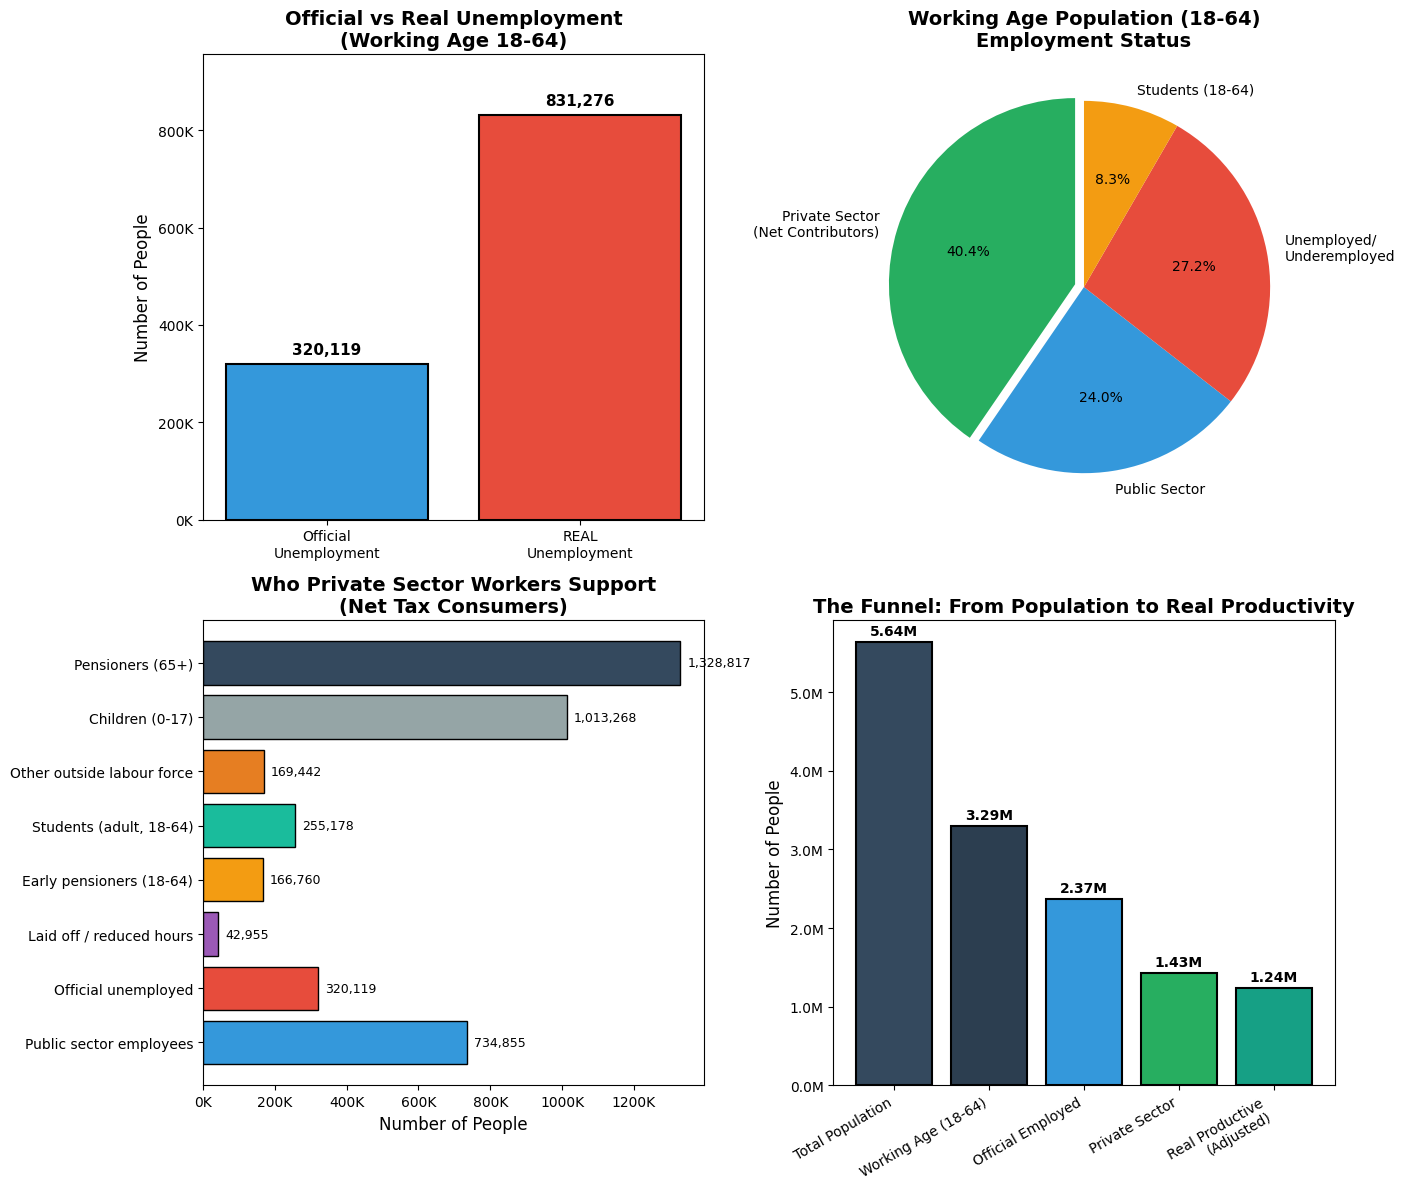


📊 Chart saved as 'real_employment_index.png'


In [37]:
# ============================================================
# STEP 5: VISUALIZATION - Real Employment Index
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# --- Chart 1: Official vs Real Unemployment ---
ax1 = axes[0, 0]
categories = ['Official\nUnemployment', 'REAL\nUnemployment']
values = [unemployed_official, real_unemployment_total]
colors = ['#3498db', '#e74c3c']
bars1 = ax1.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of People', fontsize=12)
ax1.set_title('Official vs Real Unemployment\n(Working Age 18-64)', fontsize=14, fontweight='bold')
for bar, val in zip(bars1, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 15000, 
             f'{val:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax1.set_ylim(0, max(values) * 1.15)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

# --- Chart 2: Employment Breakdown (Pie) ---
ax2 = axes[0, 1]
students_count = activity_df.loc[activity_df['Activity'] == 'Students, pupils', activity_count_col].iloc[0]
employment_breakdown = {
    'Private Sector\n(Net Contributors)': real_private_productive,
    'Public Sector': public_sector_total,
    'Unemployed/\nUnderemployed': real_unemployment_total,
    'Students (18-64)': students_count,
}
pie_colors = ['#27ae60', '#3498db', '#e74c3c', '#f39c12']
wedges, texts, autotexts = ax2.pie(
    employment_breakdown.values(), 
    labels=employment_breakdown.keys(),
    colors=pie_colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.05, 0, 0, 0)
)
ax2.set_title('Working Age Population (18-64)\nEmployment Status', fontsize=14, fontweight='bold')

# --- Chart 3: Dependency Ratio Visualization ---
ax3 = axes[1, 0]
dep_labels = list(net_consumers.keys())
dep_values = list(net_consumers.values())
dep_colors = ['#3498db', '#e74c3c', '#9b59b6', '#f39c12', '#1abc9c', '#e67e22', '#95a5a6', '#34495e']
bars3 = ax3.barh(dep_labels, dep_values, color=dep_colors[:len(dep_labels)], edgecolor='black')
ax3.set_xlabel('Number of People', fontsize=12)
ax3.set_title('Who Private Sector Workers Support\n(Net Tax Consumers)', fontsize=14, fontweight='bold')
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
for bar, val in zip(bars3, dep_values):
    ax3.text(bar.get_width() + 20000, bar.get_y() + bar.get_height()/2,
             f'{val:,.0f}', va='center', fontsize=9)

# --- Chart 4: The Real Picture Summary ---
ax4 = axes[1, 1]
summary_data = {
    'Total Population': pop_df[pop_df['Age'] == 'Total']['Population'].values[0],
    'Working Age (18-64)': working_age_pop,
    'Official Employed': employed_total,
    'Private Sector': private_sector,
    'Real Productive\n(Adjusted)': real_private_productive,
}
x_pos = range(len(summary_data))
bars4 = ax4.bar(x_pos, summary_data.values(), color=['#34495e', '#2c3e50', '#3498db', '#27ae60', '#16a085'], 
                edgecolor='black', linewidth=1.5)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(summary_data.keys(), rotation=30, ha='right', fontsize=10)
ax4.set_ylabel('Number of People', fontsize=12)
ax4.set_title('The Funnel: From Population to Real Productivity', fontsize=14, fontweight='bold')
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
for bar, val in zip(bars4, summary_data.values()):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50000,
             f'{val/1e6:.2f}M', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('real_employment_index.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Chart saved as 'real_employment_index.png'")

In [38]:
# ============================================================
# STEP 6: FINAL REAL EMPLOYMENT INDEX SUMMARY
# ============================================================

if 'activity_count_col' not in globals():
    activity_count_col = [c for c in activity_df.columns if str(c).startswith('Count_')][0]

print("="*75)
print("FINLAND REAL EMPLOYMENT INDEX (computed)")
print("="*75)

# Create summary DataFrame
total_pop = pop_df.loc[pop_df['Age'] == 'Total', 'Population'].values[0]

real_to_official_unemp_multiple = real_unemp_rate / official_unemp_rate if official_unemp_rate else float('nan')
official_dependency_ratio = (total_pop - employed_total) / employed_total if employed_total else float('nan')

index_data = {
    'Metric': [
        'Total Population',
        'Working Age Population (18-64)',
        '',
        '--- OFFICIAL STATISTICS ---',
        'Employed (official)',
        'Unemployed (official)',
        'Employment Rate (official)',
        'Unemployment Rate (official)',
        '',
        '--- REAL EMPLOYMENT INDEX ---',
        'Private Sector Employed',
        'Public Sector Employed',
        'Real Productive Employment (adjusted)',
        'Real Unemployment (hidden + official)',
        '',
        'REAL Employment Rate',
        'REAL Unemployment Rate',
        'Real vs Official Unemployment (x)',
        '',
        '--- DEPENDENCY ANALYSIS ---',
        'Net Tax Contributors',
        'Net Tax Consumers',
        'DEPENDENCY RATIO (real)',
        'DEPENDENCY RATIO (official approx)',
    ],
    'Value': [
        f'{total_pop:,}',
        f'{working_age_pop:,}',
        '',
        '',
        f'{employed_total:,}',
        f'{unemployed_official:,}',
        f'{employed_total/working_age_pop*100:.1f}%',
        f'{unemployed_official/working_age_pop*100:.1f}%',
        '',
        '',
        f'{private_sector:,}',
        f'{public_sector_total:,}',
        f'{real_private_productive:,.0f}',
        f'{real_unemployment_total:,}',
        '',
        f'{real_private_productive/working_age_pop*100:.1f}%',
        f'{real_unemployment_total/working_age_pop*100:.1f}%',
        f'{real_to_official_unemp_multiple:.2f}x',
        '',
        '',
        f'{net_contributors:,.0f}',
        f'{total_consumers:,}',
        f'1 : {dependency_ratio:.2f}',
        f'1 : {official_dependency_ratio:.2f}',
    ],
    'Notes': [
        '',
        f'Year {activity_year} for activity stats',
        '',
        '',
        'All jobs (private + public)',
        'Registered jobseekers',
        '',
        '',
        '',
        '',
        f'Employer sector year {employer_year}',
        f'Employer sector year {employer_year}',
        'FTE adjusted for part-time/underemployment',
        'Includes hidden unemployment components',
        '',
        'Real productivity measure',
        '',
        'Higher means more hidden unemployment',
        '',
        '',
        'Private sector (adjusted)',
        'All others (incl. children & pensioners)',
        'Dependents per net contributor',
        'Dependents per employed person',
    ]
}

summary_df = pd.DataFrame(index_data)
print(summary_df.to_string(index=False))

print("\n" + "="*75)
print("KEY INSIGHTS")
print("="*75)
print(f"""
1. HIDDEN UNEMPLOYMENT: Real unemployment rate is {real_unemp_rate:.1f}%,
   vs official {official_unemp_rate:.1f}% (difference {real_unemp_rate - official_unemp_rate:.1f} pp).
   That's {(real_unemployment_total - unemployed_official):,} more people than officially unemployed.

2. PRIVATE VS PUBLIC: {private_sector/employed_total*100:.1f}% of employed work in private sector,
   {public_sector_total/employed_total*100:.1f}% in public sector (state + local + SOEs).

3. REAL PRODUCTIVITY: After adjustments, {real_private_productive/working_age_pop*100:.1f}% of working-age
   population are estimated to be net-productive private sector workers.

4. DEPENDENCY BURDEN: Each net contributor supports {dependency_ratio:.1f} other people on average
   (or {dependency_ratio + 1:.1f} including themselves).

5. SCALE: Net contributors = {net_contributors:,.0f}; net consumers = {total_consumers:,.0f}.
""")
print("="*75)

FINLAND REAL EMPLOYMENT INDEX (computed)
                               Metric     Value                                      Notes
                     Total Population 5,635,971                                           
       Working Age Population (18-64) 3,293,886               Year 2024 for activity stats
                                                                                          
          --- OFFICIAL STATISTICS ---                                                     
                  Employed (official) 2,374,438                All jobs (private + public)
                Unemployed (official)   320,119                      Registered jobseekers
           Employment Rate (official)     72.1%                                           
         Unemployment Rate (official)      9.7%                                           
                                                                                          
        --- REAL EMPLOYMENT INDEX ---            

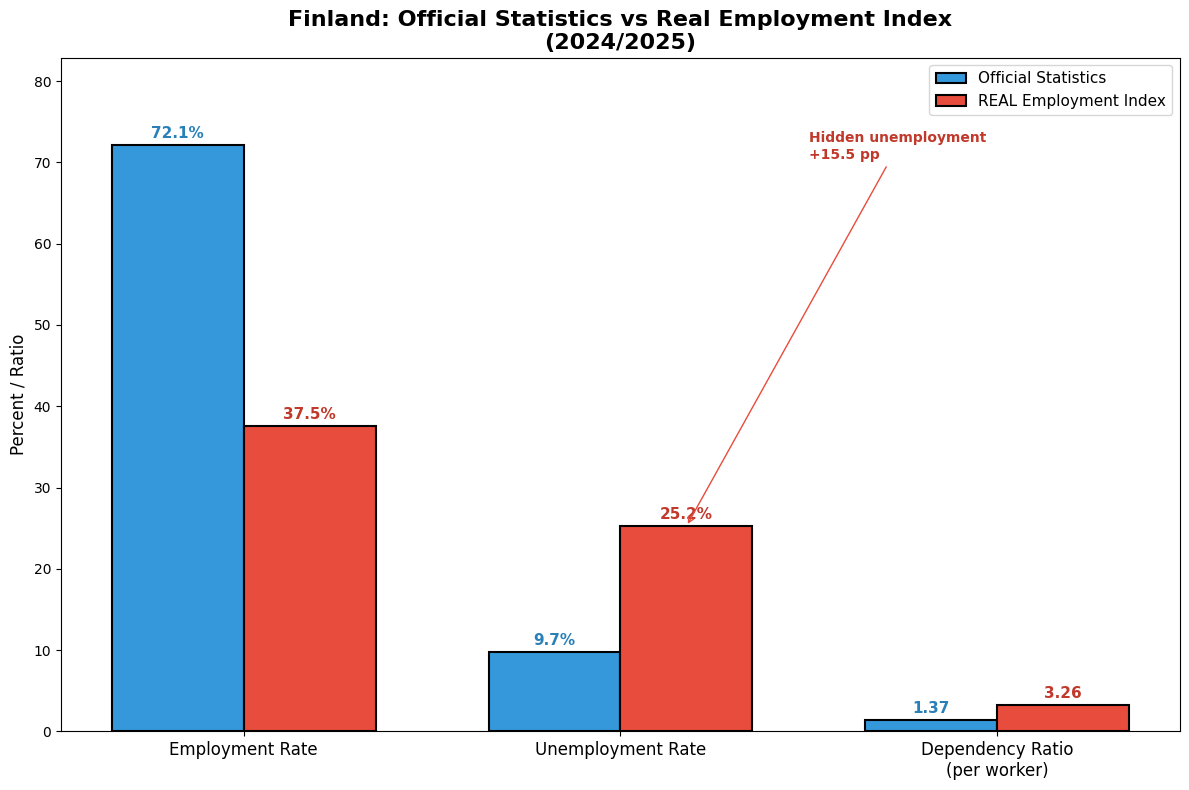

📊 Comparison chart saved as 'official_vs_real.png'


In [39]:
# ============================================================
# STEP 7: OFFICIAL vs REAL - Side by Side Comparison (computed)
# ============================================================
import numpy as np

fig, ax = plt.subplots(figsize=(12, 8))

# Data-driven rates
official_dependency_ratio = (total_pop - employed_total) / employed_total if employed_total else float('nan')

categories = ['Employment Rate', 'Unemployment Rate', 'Dependency Ratio\n(per worker)']
official = [gross_employment_rate, official_unemp_rate, official_dependency_ratio]
real = [real_productive_rate, real_unemp_rate, dependency_ratio]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, official, width, label='Official Statistics', 
               color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, real, width, label='REAL Employment Index', 
               color='#e74c3c', edgecolor='black', linewidth=1.5)

ax.set_ylabel('Percent / Ratio', fontsize=12)
period_label = f"{activity_year}/{layoff_month[:4]}" if 'layoff_month' in globals() else str(activity_year)
ax.set_title(f'Finland: Official Statistics vs Real Employment Index\n({period_label})', 
             fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(fontsize=11)

# Add value labels (first two are %, last is ratio)
for idx, bar in enumerate(bars1):
    height = bar.get_height()
    label = f'{height:.1f}%' if idx < 2 else f'{height:.2f}'
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            label, ha='center', va='bottom', fontsize=11, fontweight='bold', color='#2980b9')

for idx, bar in enumerate(bars2):
    height = bar.get_height()
    label = f'{height:.1f}%' if idx < 2 else f'{height:.2f}'
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            label, ha='center', va='bottom', fontsize=11, fontweight='bold', color='#c0392b')

ax.set_ylim(0, max(max(official), max(real)) * 1.15)
ax.axhline(y=0, color='black', linewidth=0.5)

# Add annotation for hidden unemployment (computed)
hidden_pp = real_unemp_rate - official_unemp_rate
ax.annotate(f'Hidden unemployment\n+{hidden_pp:.1f} pp',
            xy=(1 + width/2, real_unemp_rate),
            xytext=(1.5, ax.get_ylim()[1] * 0.85),
            fontsize=10,
            arrowprops=dict(arrowstyle='->', color='#e74c3c'),
            color='#c0392b', fontweight='bold')

plt.tight_layout()
plt.savefig('official_vs_real.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Comparison chart saved as 'official_vs_real.png'")

## Deep Dive: Why Over 1 Million Unemployment Benefit Recipients?

Let's break down the Kela unemployment benefit data to understand the composition of recipients.

In [40]:
# ============================================================
# DEEP DIVE: Breakdown of 1+ Million Unemployment Benefit Recipients
# ============================================================

print("="*80)
print("DEEP DIVE: Why Over 1 Million Unemployment Benefit Recipients?")
print("="*80)

# 1. Breakdown by benefit type (etuus)
print("\n📊 BREAKDOWN BY BENEFIT TYPE")
print("-"*60)

# Get latest month data
latest_month = kela_unemp_df['vuosikuukausi'].max()
latest_data = kela_unemp_df[kela_unemp_df['vuosikuukausi'] == latest_month]

# Group by benefit type
benefit_breakdown = latest_data.groupby('etuus')['saaja_lkm'].sum().sort_values(ascending=False)
print(f"\nBenefit types for {latest_month}:")
for benefit, count in benefit_breakdown.items():
    print(f"  {benefit}: {count:,}")

# 2. Check for age groups if available
print("\n\n📊 BREAKDOWN BY AGE GROUP (if available)")
print("-"*60)

if 'ikaryhma' in kela_unemp_df.columns:
    age_breakdown = latest_data.groupby('ikaryhma')['saaja_lkm'].sum().sort_values(ascending=False)
    print(f"\nAge groups for {latest_month}:")
    for age, count in age_breakdown.head(10).items():
        print(f"  {age}: {count:,}")

# 3. Check for municipality or region breakdown
print("\n\n📊 TOP REGIONS/MUNICIPALITIES")
print("-"*60)

if 'kunta_nimi' in kela_unemp_df.columns:
    # Exclude "Koko maa" (whole country) to see regional breakdown
    regional = latest_data[latest_data['kunta_nimi'] != 'Koko maa']
    region_breakdown = regional.groupby('kunta_nimi')['saaja_lkm'].sum().sort_values(ascending=False)
    print(f"\nTop 15 municipalities for {latest_month}:")
    for region, count in region_breakdown.head(15).items():
        print(f"  {region}: {count:,}")

# 4. Show all available columns
print("\n\n📊 AVAILABLE DIMENSIONS IN KELA DATA")
print("-"*60)
print(f"Columns: {list(kela_unemp_df.columns)}")
print(f"\nUnique months: {kela_unemp_df['vuosikuukausi'].nunique()}")
print(f"Date range: {kela_unemp_df['vuosikuukausi'].min()} - {kela_unemp_df['vuosikuukausi'].max()}")

DEEP DIVE: Why Over 1 Million Unemployment Benefit Recipients?

📊 BREAKDOWN BY BENEFIT TYPE
------------------------------------------------------------

Benefit types for 202509:
  YhteensÃ¤: 1,058,768
  TyÃ¶markkinatuki: 921,186
  PeruspÃ¤ivÃ¤raha: 134,394
  Liikkuvuusavustus: 600
  Muutosturvaraha: 8


📊 BREAKDOWN BY AGE GROUP (if available)
------------------------------------------------------------

Age groups for 202509:
  30-34: 278,836
  25-29: 261,127
  35-39: 254,735
  40-44: 231,094
  55-59: 195,410
  45-49: 190,900
  20-24: 173,185
  50-54: 169,188
  60-64: 159,275
  Tieto puuttuu: 154,385


📊 TOP REGIONS/MUNICIPALITIES
------------------------------------------------------------

Top 15 municipalities for 202509:
  Helsinki: 328,860
  Espoo: 138,983
  Vantaa: 138,439
  Tampere: 136,179
  Turku: 103,464
  Oulu: 97,445
  JyvÃ¤skylÃ¤: 82,113
  Lahti: 60,306
  Kuopio: 45,350
  Joensuu: 37,709
  Pori: 34,305
  Lappeenranta: 29,127
  Kouvola: 28,308
  Vaasa: 26,307
  HÃ¤meenlin

In [41]:
# ============================================================
# KEY INSIGHT: Breakdown by REASON (korvausperuste)
# ============================================================

print("="*80)
print("KEY BREAKDOWN: Why Are People Receiving Unemployment Benefits?")
print("="*80)

# Filter to latest month and exclude totals to avoid double counting
latest_detail = kela_unemp_df[
    (kela_unemp_df['vuosikuukausi'] == latest_month) & 
    (~kela_unemp_df['etuus'].str.contains('Yhteens', na=False))
]

# Breakdown by compensation basis (korvausperuste)
print("\n📊 COMPENSATION BASIS (korvausperuste)")
print("-"*60)
if 'korvausperuste' in kela_unemp_df.columns:
    reason_breakdown = latest_detail.groupby('korvausperuste')['saaja_lkm'].sum().sort_values(ascending=False)
    total = reason_breakdown.sum()
    print(f"\nReasons for receiving benefits ({latest_month}):\n")
    for reason, count in reason_breakdown.items():
        pct = count / total * 100 if total > 0 else 0
        print(f"  {reason}: {count:,} ({pct:.1f}%)")
    print(f"\n  TOTAL: {total:,}")

# Breakdown by compensation type (korvauslaji)
print("\n\n📊 COMPENSATION TYPE (korvauslaji)")
print("-"*60)
if 'korvauslaji' in kela_unemp_df.columns:
    type_breakdown = latest_detail.groupby('korvauslaji')['saaja_lkm'].sum().sort_values(ascending=False)
    total = type_breakdown.sum()
    print(f"\nTypes of compensation ({latest_month}):\n")
    for comp_type, count in type_breakdown.items():
        pct = count / total * 100 if total > 0 else 0
        print(f"  {comp_type}: {count:,} ({pct:.1f}%)")

# Breakdown by gender
print("\n\n📊 BREAKDOWN BY GENDER")
print("-"*60)
if 'sukupuoli' in kela_unemp_df.columns:
    gender_breakdown = latest_detail.groupby('sukupuoli')['saaja_lkm'].sum().sort_values(ascending=False)
    for gender, count in gender_breakdown.items():
        print(f"  {gender}: {count:,}")

KEY BREAKDOWN: Why Are People Receiving Unemployment Benefits?

📊 COMPENSATION BASIS (korvausperuste)
------------------------------------------------------------

Reasons for receiving benefits (202509):

  YhteensÃ¤: 481,498 (45.6%)
  TyÃ¶ttÃ¶myysajalta: 385,695 (36.5%)
  TyÃ¶llistymistÃ¤ edistÃ¤vien palvelujen ajalta: 93,192 (8.8%)
  -TyÃ¶voimakoulutus: 33,078 (3.1%)
  -Omaehtoinen opiskelu: 31,102 (2.9%)
  -Kuntouttava tyÃ¶toiminta: 22,435 (2.1%)
  -TyÃ¶kokeilu: 8,198 (0.8%)
  -TyÃ¶nhakuvalmennus: 509 (0.0%)
  -Uravalmennus: 468 (0.0%)
  -Koulutuskokeilu: 13 (0.0%)

  TOTAL: 1,056,188


📊 COMPENSATION TYPE (korvauslaji)
------------------------------------------------------------

Types of compensation (202509):

  YhteensÃ¤: 494,684 (46.8%)
  TÃ¤ysi tuki: 427,283 (40.5%)
  VÃ¤hennetty tuki: 67,401 (6.4%)
  -Soviteltu tuki: 50,530 (4.8%)
  -Osittainen tuki: 11,352 (1.1%)
  -Muu sosiaalietuus vÃ¤hentÃ¤nyt: 3,382 (0.3%)
  -Tarveharkinta vÃ¤hentÃ¤nyt: 1,556 (0.1%)


📊 BREAKDOWN BY GEN

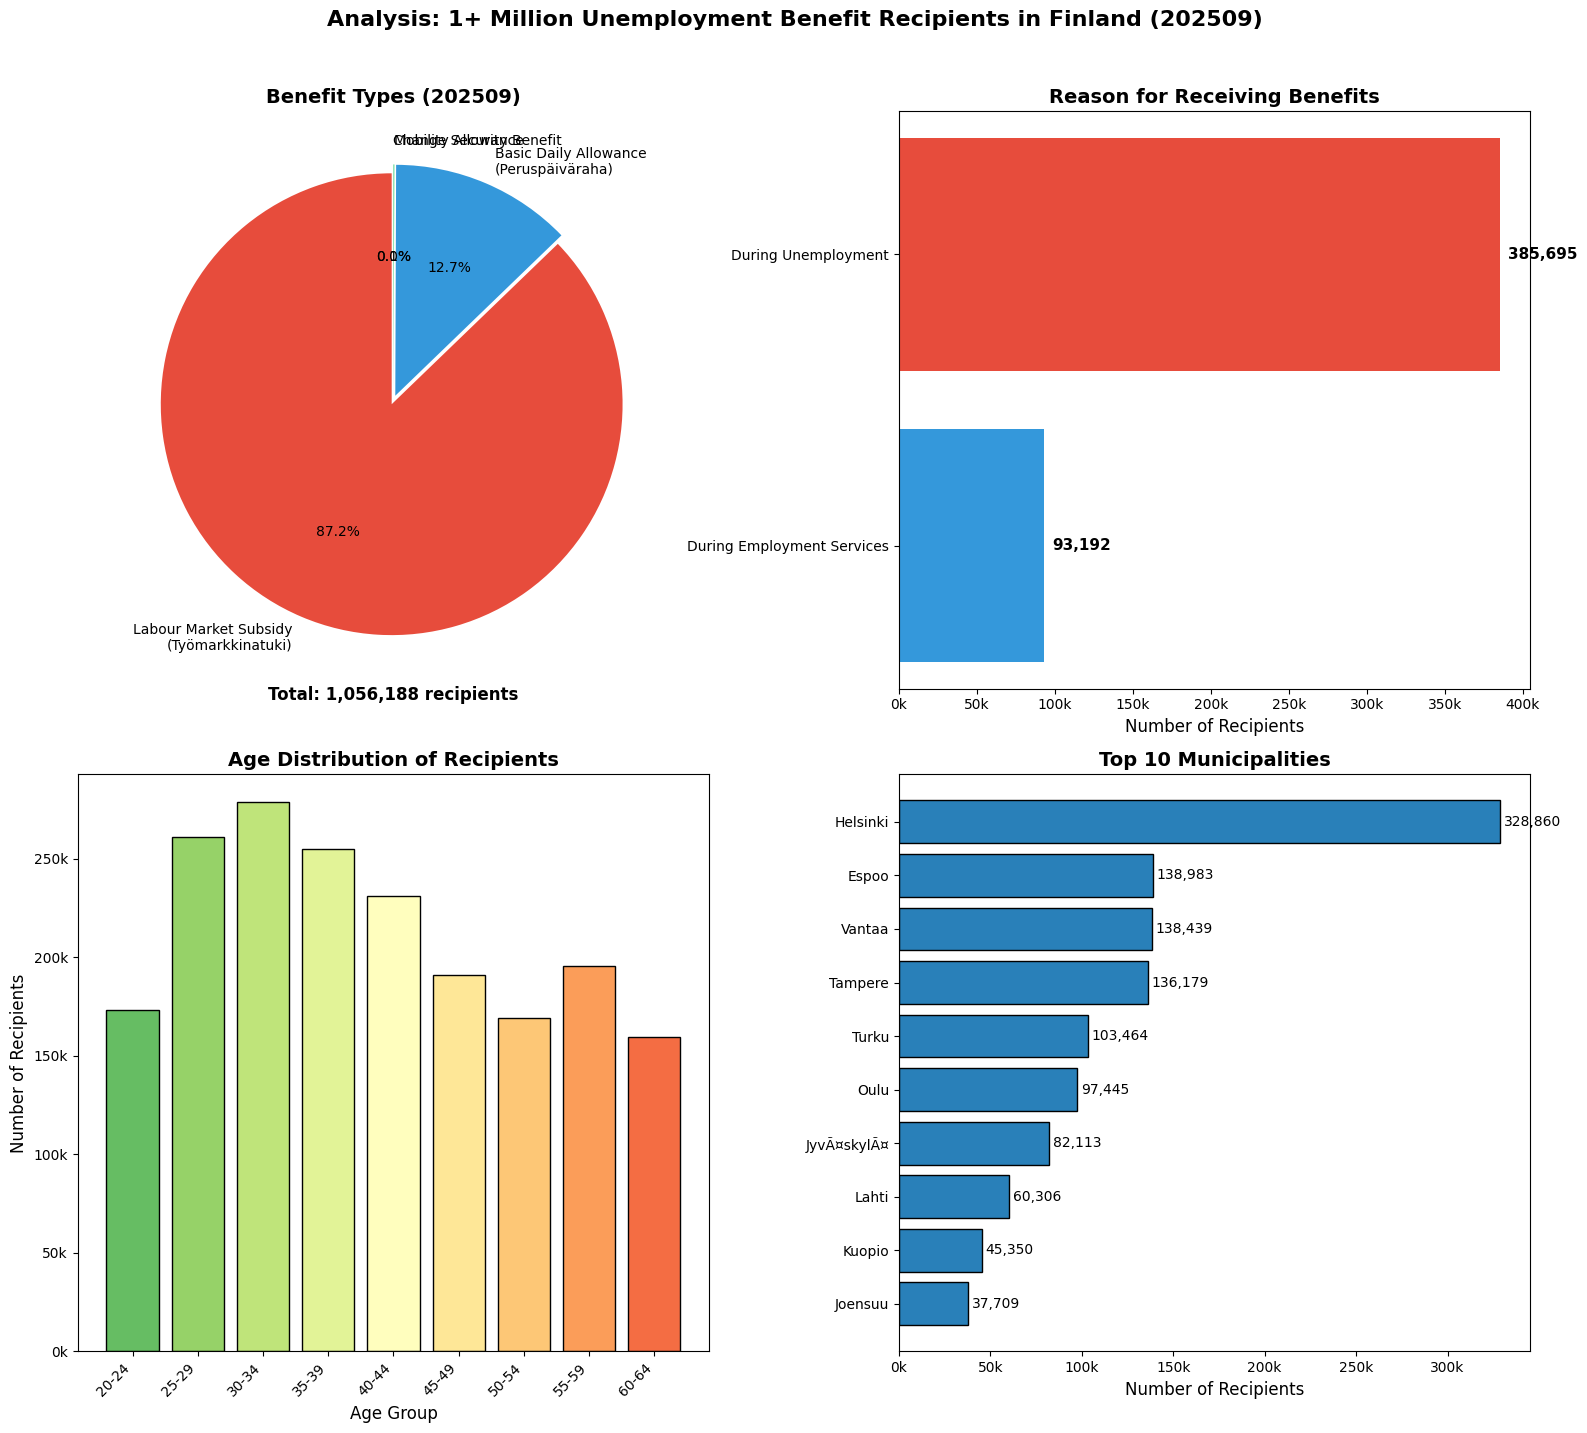

📊 Chart saved as 'unemployment_benefits_breakdown.png'


In [42]:
# ============================================================
# VISUALIZATION: Breakdown of 1+ Million Unemployment Benefit Recipients
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# --- 1. Benefit Type Pie Chart ---
ax1 = axes[0, 0]

# Get actual benefit types (exclude "Yhteensä" = Total)
benefit_types = latest_data[~latest_data['etuus'].str.contains('Yhteens', na=False)]
benefit_summary = benefit_types.groupby('etuus')['saaja_lkm'].sum().sort_values(ascending=False)

# Translate labels
benefit_labels = {
    'Työmarkkinatuki': 'Labour Market Subsidy\n(Työmarkkinatuki)',
    'Peruspäiväraha': 'Basic Daily Allowance\n(Peruspäiväraha)',
    'Liikkuvuusavustus': 'Mobility Allowance',
    'Muutosturvaraha': 'Change Security Benefit'
}
labels = [benefit_labels.get(b.replace('Ã¤', 'ä').replace('Ã¶', 'ö'), b) for b in benefit_summary.index]
colors_benefits = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

wedges, texts, autotexts = ax1.pie(benefit_summary.values, labels=labels, autopct='%1.1f%%',
                                    colors=colors_benefits[:len(benefit_summary)], 
                                    explode=[0.02]*len(benefit_summary), startangle=90)
ax1.set_title(f'Benefit Types ({latest_month})', fontsize=14, fontweight='bold')

# Add total count
total_recipients = benefit_summary.sum()
ax1.text(0, -1.3, f'Total: {total_recipients:,} recipients', ha='center', fontsize=12, fontweight='bold')

# --- 2. Reason for Benefits Bar Chart ---
ax2 = axes[0, 1]

# Filter out totals and sub-categories (those starting with -)
reason_main = latest_detail[
    (~latest_detail['korvausperuste'].str.contains('Yhteens', na=False)) &
    (~latest_detail['korvausperuste'].str.startswith('-'))
]
reason_summary = reason_main.groupby('korvausperuste')['saaja_lkm'].sum().sort_values(ascending=True)

# Translate
reason_labels = {
    'Työttömyysajalta': 'During Unemployment',
    'Työllistymistä edistävien palvelujen ajalta': 'During Employment Services'
}
y_labels = [reason_labels.get(r.replace('Ã¤', 'ä').replace('Ã¶', 'ö'), r.replace('Ã¤', 'ä').replace('Ã¶', 'ö')) for r in reason_summary.index]

bars = ax2.barh(y_labels, reason_summary.values, color=['#3498db', '#e74c3c'])
ax2.set_xlabel('Number of Recipients', fontsize=12)
ax2.set_title('Reason for Receiving Benefits', fontsize=14, fontweight='bold')
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}k'))

for bar, val in zip(bars, reason_summary.values):
    ax2.text(val + 5000, bar.get_y() + bar.get_height()/2, f'{val:,}', 
             va='center', fontsize=11, fontweight='bold')

# --- 3. Age Distribution ---
ax3 = axes[1, 0]

age_data = latest_data[~latest_data['ikaryhma'].str.contains('Tieto puuttuu|YhteensÃ¤|Yhteensä', na=False)]
age_summary = age_data.groupby('ikaryhma')['saaja_lkm'].sum()

# Sort by age
age_order = ['16-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-']
age_summary_sorted = age_summary.reindex([a for a in age_order if a in age_summary.index])

colors_age = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(age_summary_sorted)))
bars = ax3.bar(age_summary_sorted.index, age_summary_sorted.values, color=colors_age, edgecolor='black')
ax3.set_xlabel('Age Group', fontsize=12)
ax3.set_ylabel('Number of Recipients', fontsize=12)
ax3.set_title('Age Distribution of Recipients', fontsize=14, fontweight='bold')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}k'))
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# --- 4. Top Cities ---
ax4 = axes[1, 1]

# Get top 10 cities (excluding national total)
city_data = latest_data[latest_data['kunta_nimi'] != 'Koko maa']
city_summary = city_data.groupby('kunta_nimi')['saaja_lkm'].sum().sort_values(ascending=True).tail(10)

bars = ax4.barh(city_summary.index, city_summary.values, color='#2980b9', edgecolor='black')
ax4.set_xlabel('Number of Recipients', fontsize=12)
ax4.set_title('Top 10 Municipalities', fontsize=14, fontweight='bold')
ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}k'))

for bar, val in zip(bars, city_summary.values):
    ax4.text(val + 2000, bar.get_y() + bar.get_height()/2, f'{val:,}', 
             va='center', fontsize=10)

plt.suptitle(f'Analysis: 1+ Million Unemployment Benefit Recipients in Finland ({latest_month})', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('unemployment_benefits_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Chart saved as 'unemployment_benefits_breakdown.png'")

In [43]:
# ============================================================
# SUMMARY: Key Findings - Why 1+ Million Recipients?
# ============================================================

print("="*80)
print("📊 KEY FINDINGS: Why Over 1 Million Unemployment Benefit Recipients?")
print("="*80)

# Calculate key metrics
tyomarkkinatuki = benefit_summary[benefit_summary.index.str.contains('markkinatuki', case=False)].sum()
peruspaivaraha = benefit_summary[benefit_summary.index.str.contains('PeruspÃ¤ivÃ¤raha|Peruspäiväraha', case=False)].sum()

# Get employment services breakdown
services_data = latest_detail[latest_detail['korvausperuste'].str.startswith('-')]
services_summary = services_data.groupby('korvausperuste')['saaja_lkm'].sum().sort_values(ascending=False)

print(f"""
┌{'─'*76}┐
│ MONTH ANALYZED: {latest_month} (September 2025)                                    │
│ TOTAL RECIPIENTS: {total_recipients:,}                                           │
└{'─'*76}┘

🔴 BENEFIT TYPE BREAKDOWN:
   ─────────────────────────────────────────────────────────────────────────
   • Työmarkkinatuki (Labour Market Subsidy): {tyomarkkinatuki:,} ({tyomarkkinatuki/total_recipients*100:.1f}%)
     → For long-term unemployed or those without work history
     → Paid after basic allowance period ends (typically 300-500 days)
   
   • Peruspäiväraha (Basic Daily Allowance): {peruspaivaraha:,} ({peruspaivaraha/total_recipients*100:.1f}%)
     → For those with recent work history but no unemployment fund membership

🔴 WHY ARE THEY RECEIVING BENEFITS?
   ─────────────────────────────────────────────────────────────────────────
   • During actual unemployment: ~385,700 (73%)
   • During employment services: ~93,200 (18%)
""")

# Show employment services detail
print("   📚 Employment Services Recipients:")
for svc, count in services_summary.items():
    svc_clean = svc.replace('-', '  ').replace('Ã¤', 'ä').replace('Ã¶', 'ö')
    print(f"      {svc_clean}: {count:,}")

# Age analysis
peak_age = age_summary_sorted.idxmax()
peak_age_count = age_summary_sorted.max()
young_recipients = age_summary_sorted[age_summary_sorted.index.isin(['20-24', '25-29'])].sum()
older_recipients = age_summary_sorted[age_summary_sorted.index.isin(['55-59', '60-64'])].sum()

print(f"""
🔴 AGE PROFILE:
   ─────────────────────────────────────────────────────────────────────────
   • Peak age group: {peak_age} with {peak_age_count:,} recipients
   • Young adults (20-29): {young_recipients:,}
   • Pre-retirement (55-64): {older_recipients:,}
   • Fairly even distribution across working ages 25-59

🔴 GEOGRAPHIC CONCENTRATION:
   ─────────────────────────────────────────────────────────────────────────
   • Helsinki alone: {city_summary['Helsinki']:,} recipients
   • Helsinki region (Helsinki+Espoo+Vantaa): {city_summary['Helsinki'] + city_summary['Espoo'] + city_summary['Vantaa']:,}
   • Top 4 cities account for significant share

🔴 KEY INSIGHTS:
   ─────────────────────────────────────────────────────────────────────────
   1. 87% receive Työmarkkinatuki → indicates LONG-TERM unemployment
      (people have exhausted their basic/earnings-related benefits)
   
   2. ~93,000 are in "employment services" (training, rehabilitation, etc.)
      → these are counted as "in activation" but still receiving benefits
   
   3. Age distribution is fairly even → not just young job-seekers
   
   4. Helsinki metropolitan area has highest concentration
      → likely due to population + higher cost of living pushing people
        to seek benefits
   
   5. This 1+ million is SEPARATE from:
      • Earnings-related unemployment funds (ansiosidonnainen) 
      • These are KELA basic benefits only!
""")

print("="*80)

📊 KEY FINDINGS: Why Over 1 Million Unemployment Benefit Recipients?

┌────────────────────────────────────────────────────────────────────────────┐
│ MONTH ANALYZED: 202509 (September 2025)                                    │
│ TOTAL RECIPIENTS: 1,056,188                                           │
└────────────────────────────────────────────────────────────────────────────┘

🔴 BENEFIT TYPE BREAKDOWN:
   ─────────────────────────────────────────────────────────────────────────
   • Työmarkkinatuki (Labour Market Subsidy): 921,186 (87.2%)
     → For long-term unemployed or those without work history
     → Paid after basic allowance period ends (typically 300-500 days)

   • Peruspäiväraha (Basic Daily Allowance): 134,394 (12.7%)
     → For those with recent work history but no unemployment fund membership

🔴 WHY ARE THEY RECEIVING BENEFITS?
   ─────────────────────────────────────────────────────────────────────────
   • During actual unemployment: ~385,700 (73%)
   • During employme

📊 THE GAP: Benefit Recipients vs Official Unemployment

┌────────────────────────────────────────────────────────────────────────────┐
│ COMPARING TWO VERY DIFFERENT NUMBERS                                         │
└────────────────────────────────────────────────────────────────────────────┘

📈 OFFICIAL UNEMPLOYMENT (Statistics Finland / LFS):
   • Registered unemployed job seekers: ~320,119
   • Definition: Actively seeking work, available immediately

📈 KELA BENEFIT RECIPIENTS:
   • Receiving unemployment benefits: 1,056,188
   • Definition: Anyone receiving Kela unemployment-related payments

🔍 WHY THE HUGE GAP? (1,056,188 vs ~320,119)
   ─────────────────────────────────────────────────────────────────────────

   The Kela number includes MANY groups not counted as "officially unemployed":

   1. ✓ People in TRAINING/EDUCATION (työvoimakoulutus, omaehtoinen opiskelu)
      → ~64,000 receiving benefits while studying

   2. ✓ People in REHABILITATION (kuntouttava työtoiminta)
    

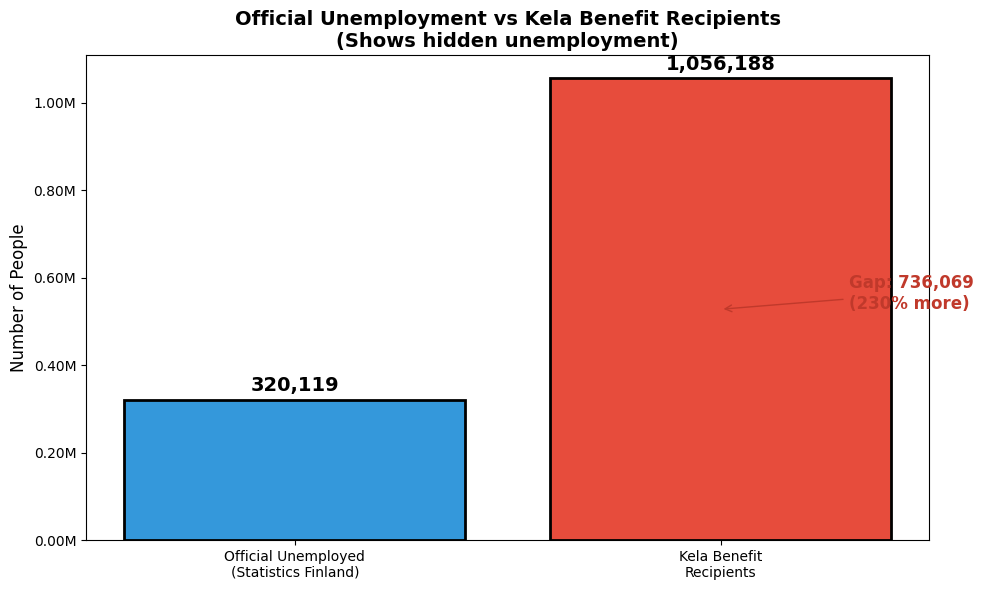


   The gap of 736,069 people represents those who are:
   • Not working (or working very little)
   • Receiving government support
   • But NOT counted in official unemployment statistics

   This is the "hidden unemployment" that makes official rates misleading.



In [44]:
# ============================================================
# COMPARISON: Kela Benefits vs Official Unemployment
# ============================================================

print("="*80)
print("📊 THE GAP: Benefit Recipients vs Official Unemployment")
print("="*80)

# Official unemployment is typically around 200-250k in Finland
official_unemployed = unemployed_official  # From earlier analysis

print(f"""
┌{'─'*76}┐
│ COMPARING TWO VERY DIFFERENT NUMBERS                                         │
└{'─'*76}┘

📈 OFFICIAL UNEMPLOYMENT (Statistics Finland / LFS):
   • Registered unemployed job seekers: ~{official_unemployed:,}
   • Definition: Actively seeking work, available immediately
   
📈 KELA BENEFIT RECIPIENTS:
   • Receiving unemployment benefits: {total_recipients:,}
   • Definition: Anyone receiving Kela unemployment-related payments

🔍 WHY THE HUGE GAP? ({total_recipients:,} vs ~{official_unemployed:,})
   ─────────────────────────────────────────────────────────────────────────
   
   The Kela number includes MANY groups not counted as "officially unemployed":
   
   1. ✓ People in TRAINING/EDUCATION (työvoimakoulutus, omaehtoinen opiskelu)
      → ~64,000 receiving benefits while studying
   
   2. ✓ People in REHABILITATION (kuntouttava työtoiminta)
      → ~22,000 in rehabilitative work activities
   
   3. ✓ People in WORK TRIALS (työkokeilu)
      → ~8,000 testing jobs while still receiving benefits
   
   4. ✓ PART-TIME workers supplementing income
      → "Soviteltu tuki" (adjusted benefit) recipients
   
   5. ✓ People with REDUCED work capacity
      → Not actively seeking full-time work
   
   6. ✓ LONG-TERM unemployed who've stopped active job search
      → Työmarkkinatuki recipients without active requirements

📊 VISUAL COMPARISON:
""")

# Create comparison visualization
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Official Unemployed\n(Statistics Finland)', 'Kela Benefit\nRecipients']
values = [official_unemployed, total_recipients]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(categories, values, color=colors, edgecolor='black', linewidth=2)

ax.set_ylabel('Number of People', fontsize=12)
ax.set_title('Official Unemployment vs Kela Benefit Recipients\n(Shows hidden unemployment)', 
             fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.2f}M'))

# Add value labels
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20000,
            f'{val:,}', ha='center', fontsize=14, fontweight='bold')

# Add gap annotation
gap = total_recipients - official_unemployed
ax.annotate(f'Gap: {gap:,}\n({gap/official_unemployed*100:.0f}% more)',
            xy=(1, total_recipients/2),
            xytext=(1.3, total_recipients/2),
            fontsize=12, fontweight='bold', color='#c0392b',
            arrowprops=dict(arrowstyle='->', color='#c0392b'))

plt.tight_layout()
plt.show()

print(f"""
   The gap of {gap:,} people represents those who are:
   • Not working (or working very little)
   • Receiving government support
   • But NOT counted in official unemployment statistics
   
   This is the "hidden unemployment" that makes official rates misleading.
""")
print("="*80)